# Processing the High Diamond Dataset
First, I import Pandas to handle the data and use a special setting that allows me to see all columns at any given time.

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

Now I import the data and take a peek at it.

In [3]:
df = pd.read_csv('../archive/high_diamond_ranked_10min.csv')

In [4]:
df.head(5)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


## Removing Extraneous Columns
Here, I use the `.corr()` and `.stack()` methods to investigate the correlations in the data.

In [5]:
correlations = df.corr().stack().reset_index()

#level_0 and level_1 are created when you reset the index
correlations['pair'] = correlations['level_0']+'|'+correlations['level_1']

#turning the pair column into a list
correlations['pair'] = correlations['pair'].map(lambda x: sorted(x.split('|')))

#removing any rows that show a correlation between a feature and itself by checking that the
#set of unique values is not equal to 1
correlations = correlations.loc[correlations['pair'].map(lambda x: len(set(x))) != 1]

#changing the pair column back into a string
correlations['pair'] = correlations['pair'].map(lambda x: ', '.join(x))

correlations.head()

,level_0,level_1,0,pair
1,gameId,blueWins,0.000985,"blueWins, gameId"
2,gameId,blueWardsPlaced,0.005361,"blueWardsPlaced, gameId"
3,gameId,blueWardsDestroyed,-0.012057,"blueWardsDestroyed, gameId"
4,gameId,blueFirstBlood,-0.011577,"blueFirstBlood, gameId"
5,gameId,blueKills,-0.038993,"blueKills, gameId"


Now, let's drop the unneeded `level_0` and `level_1` columns, as well as duplicate rows.

In [6]:
correlations.drop(['level_0','level_1'], axis = 1, inplace = True)
correlations.drop_duplicates(inplace = True)

correlations.head()

,0,pair
1,0.000985,"blueWins, gameId"
2,0.005361,"blueWardsPlaced, gameId"
3,-0.012057,"blueWardsDestroyed, gameId"
4,-0.011577,"blueFirstBlood, gameId"
5,-0.038993,"blueKills, gameId"


Now we make sure to look at the absolute value of correlation, and set our index to `pair`

In [7]:
correlations[0] = abs(correlations[0])
correlations.set_index('pair', inplace = True)

Now let's just look for any thing that has perfect correlation. We aren't concerned with high correlations, as the models that we use aren't that sensitive to multicollinearity issues.

In [8]:
correlations.loc[correlations[0] >= 0.95]

,0
pair,
"blueFirstBlood, redFirstBlood",1.0
"blueKills, redDeaths",1.0
"blueDeaths, redKills",1.0
"blueGoldPerMin, blueTotalGold",1.0
"blueCSPerMin, blueTotalMinionsKilled",1.0
"blueGoldDiff, redGoldDiff",1.0
"blueExperienceDiff, redExperienceDiff",1.0
"redGoldPerMin, redTotalGold",1.0
"redCSPerMin, redTotalMinionsKilled",1.0


For each highly correlated pair, we remove one of the columns. Here, we also remove `blueEliteMonsters` and `redEliteMonsters`, as we feel that this is too easy to garner from the `Dragons` and `Heralds` columns.

In [9]:
df.drop(['blueDeaths','redDeaths','blueTotalGold','redTotalGold','redGoldDiff','redExperienceDiff',
         'redFirstBlood','blueTotalMinionsKilled','redTotalMinionsKilled','blueEliteMonsters',
         'redEliteMonsters'], axis = 1, inplace = True)

Now that we've dropped those columns, let's check one more time for perfect correlations.

In [10]:
correlations = df.corr().stack().reset_index()
correlations['pair'] = correlations['level_0']+'|'+correlations['level_1']
correlations['pair'] = correlations['pair'].map(lambda x: sorted(x.split('|')))
correlations = correlations.loc[correlations['pair'].map(lambda x: len(set(x))) != 1]
correlations['pair'] = correlations['pair'].map(lambda x: ', '.join(x))

In [11]:
correlations.drop(['level_0','level_1'], axis = 1, inplace = True)
correlations.drop_duplicates(inplace = True)

In [12]:
correlations[0] = abs(correlations[0])
correlations.set_index('pair', inplace = True)

In [13]:
correlations.sort_values(by = 0, inplace = True)

In [14]:
correlations.loc[correlations[0] >= 0.95]

,0
pair,


Perfect! Now we don't have any extraneous columns.  
### Quick Renaming
Let's peek at the `WardsPlaced` columns

In [15]:
df['blueWardsPlaced'].describe()

count    9879.000000
mean       22.288288
std        18.019177
min         5.000000
25%        14.000000
50%        16.000000
75%        20.000000
max       250.000000
Name: blueWardsPlaced, dtype: float64

250 as the maximum seems like an impossible number. The team agrees that the `WardsPlaced` columns are probably actually indicative of `VisionScore`, a metric of vision that League of Legends creates based on wards. We rename these columns here.

In [16]:
df.columns = df.columns.map(lambda x: 'blueVisionScore' if x == 'blueWardsPlaced'
                           else 'redVisionScore' if x == 'redWardsPlaced'
                           else x)

In [17]:
df.columns

Index(['gameId', 'blueWins', 'blueVisionScore', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueAssists', 'blueDragons',
       'blueHeralds', 'blueTowersDestroyed', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalJungleMinionsKilled', 'blueGoldDiff',
       'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin',
       'redVisionScore', 'redWardsDestroyed', 'redKills', 'redAssists',
       'redDragons', 'redHeralds', 'redTowersDestroyed', 'redAvgLevel',
       'redTotalExperience', 'redTotalJungleMinionsKilled', 'redCSPerMin',
       'redGoldPerMin'],
      dtype='object')

## Champion Data
### API Calls
Now, we are going to use the `gameId` column to make API calls to the Riot APIs. We use this to gather more data about the games.  
First, we import the necessary modules.

In [18]:
#for making the calls
import requests

#for parsing the calls
import json

#to limit the rate of calls
from time import sleep

First, lets isolate the game IDs from the dataframe.

In [19]:
gameids = df['gameId']

In [20]:
gameids

0       4519157822
1       4523371949
2       4521474530
3       4524384067
4       4436033771
           ...    
9874    4527873286
9875    4527797466
9876    4527713716
9877    4527628313
9878    4523772935
Name: gameId, Length: 9879, dtype: int64

#### Making the call
Here, the code actually makes the API calls. This takes several hours to run, and requires that one have a Riot API key. The key goes where it says `YOUR-KEY-HERE` in the code. As this code takes forever to run, it is commented out here.

In [21]:
# champions_list = []
# count = 0
# for id_ in gameids:
#     count += 1
#     print(count, end = ', ')
#     url = f'https://euw1.api.riotgames.com/lol/match/v4/matches/{id_}?api_key=YOUR-KEY-HERE'
#     got = requests.get(url)
#     match = json.loads(got.text)
#     sleep(1.2)
    
#     participants = match['participants']
    
#     champs = [(p['participantId'], p['teamId'], p['championId'],
#                p['timeline']['role'], p['timeline']['lane']) for p in participants]
#     champions_list.append(champs)
# champions = pd.DataFrame({'champions':champions_list})

Instead, we import the data obtained in previous calls from the archive folder.

In [22]:
champions_data = pd.read_csv('../archive/champions.csv')

In [23]:
champions_data.head()

,champions
0,"[(1, 100, 111, 'DUO_SUPPORT', 'BOTTOM'), (2, 1..."
1,"[(1, 100, 4, 'DUO_SUPPORT', 'NONE'), (2, 100, ..."
2,"[(1, 100, 421, 'NONE', 'JUNGLE'), (2, 100, 84,..."
3,"[(1, 100, 64, 'NONE', 'JUNGLE'), (2, 100, 134,..."
4,"[(1, 100, 101, 'DUO', 'TOP'), (2, 100, 266, 'D..."


As this is imported data from a csv file, the nested tuple/list structure is actually a string. Let's look at a sample of the data to investigate this further.

In [24]:
sample = champions_data['champions'].iloc[0]

In [25]:
sample

"[(1, 100, 111, 'DUO_SUPPORT', 'BOTTOM'), (2, 100, 91, 'SOLO', 'MIDDLE'), (3, 100, 236, 'DUO_CARRY', 'BOTTOM'), (4, 100, 76, 'NONE', 'JUNGLE'), (5, 100, 54, 'SOLO', 'TOP'), (6, 200, 26, 'DUO_CARRY', 'BOTTOM'), (7, 200, 235, 'DUO_SUPPORT', 'BOTTOM'), (8, 200, 82, 'SOLO', 'TOP'), (9, 200, 421, 'NONE', 'JUNGLE'), (10, 200, 69, 'SOLO', 'MIDDLE')]"

It is indeed a string. Here, the data is formatted as follows: `(ParticipantID, TeamID, ChampionID, Role, Lane)`.  
We are going to attempt to extract just the champion IDs from the data.

In [26]:
import re
pattern = re.compile(r"(100|200), ")
splitted = pattern.split(sample)
[string.split(',')[0] for string in splitted][2:21:2]

['111', '91', '236', '76', '54', '26', '235', '82', '421', '69']

Great! Let's put this code in a function and use `.map()` to apply it to all the champion data.

In [27]:
def reformat(champs):
    pattern = re.compile(r"(100|200), ")
    splitted = pattern.split(champs)
    return [string.split(',')[0] for string in splitted][2:21:2]

In [28]:
champion_ids = champions_data['champions'].map(reformat)

We also need to change all the strings to integers. We do that below.

In [29]:
champion_ids = champion_ids.map(lambda x: [int(y) for y in x])

In [30]:
champion_ids

0           [111, 91, 236, 76, 54, 26, 235, 82, 421, 69]
1           [4, 350, 75, 145, 875, 110, 59, 53, 134, 39]
2         [421, 84, 236, 43, 45, 145, 154, 92, 134, 223]
3       [64, 134, 516, 432, 429, 110, 412, 58, 245, 238]
4          [101, 266, 245, 143, 21, 51, 86, 69, 235, 32]
                              ...                       
9874         [21, 26, 104, 122, 43, 40, 81, 38, 517, 98]
9875       [432, 110, 420, 48, 45, 59, 61, 114, 235, 58]
9876      [145, 62, 555, 268, 427, 14, 26, 69, 102, 110]
9877         [38, 24, 20, 412, 18, 98, 429, 421, 16, 39]
9878       [517, 267, 145, 238, 20, 64, 18, 134, 555, 1]
Name: champions, Length: 9879, dtype: object

Now, let's create separate series for the blue and red teams. As team ID `100` represents blue, we can be sure that the first 5 champion IDs are for the blue team, and the rest for the red team.

In [31]:
blue_champion_ids = champion_ids.map(lambda x: x[:5])
red_champion_ids = champion_ids.map(lambda x: x[5:])

Let's check that every team has 5 champions.

In [32]:
((blue_champion_ids.map(len)) == 5).all()

True

In [33]:
((red_champion_ids.map(len)) == 5).all()

True

In [34]:
((blue_champion_ids + red_champion_ids) == champion_ids).all()

True

### Scraping to translate Champion Data
Now, let's use a specific url provided by Riot to translate all these champion IDs into champion names.

We need to make an additional import to do this.

In [35]:
#for html parsing
from bs4 import BeautifulSoup

Here, we get the data.

In [36]:
request = requests.get('http://ddragon.leagueoflegends.com/cdn/11.14.1/data/en_US/champion.json')

Now we parse it into soup.

In [37]:
soup = BeautifulSoup(request.text, 'lxml')

We look for the first `'p'` tag.

In [38]:
dict_string = soup.find_all('p')[0].text

And use `json` to load the data.

In [39]:
dictionary = json.loads(dict_string)

In [40]:
dictionary.keys()

dict_keys(['type', 'format', 'version', 'data'])

Let's pull just the actual data from this json and look at the formatting of it.

In [41]:
champions = dictionary['data']

In [42]:
champions['Aatrox']

{'version': '11.14.1',
 'id': 'Aatrox',
 'key': '266',
 'name': 'Aatrox',
 'title': 'the Darkin Blade',
 'blurb': 'Once honored defenders of Shurima against the Void, Aatrox and his brethren would eventually become an even greater threat to Runeterra, and were defeated only by cunning mortal sorcery. But after centuries of imprisonment, Aatrox was the first to find...',
 'info': {'attack': 8, 'defense': 4, 'magic': 3, 'difficulty': 4},
 'image': {'full': 'Aatrox.png',
  'sprite': 'champion0.png',
  'group': 'champion',
  'x': 0,
  'y': 0,
  'w': 48,
  'h': 48},
 'tags': ['Fighter', 'Tank'],
 'partype': 'Blood Well',
 'stats': {'hp': 580,
  'hpperlevel': 90,
  'mp': 0,
  'mpperlevel': 0,
  'movespeed': 345,
  'armor': 38,
  'armorperlevel': 3.25,
  'spellblock': 32,
  'spellblockperlevel': 1.25,
  'attackrange': 175,
  'hpregen': 3,
  'hpregenperlevel': 1,
  'mpregen': 0,
  'mpregenperlevel': 0,
  'crit': 0,
  'critperlevel': 0,
  'attackdamage': 60,
  'attackdamageperlevel': 5,
  'atta

We need to map names to keys and vice-versa. We make dictionaries to do this.

In [43]:
champ_to_num = {data['name'] : int(data['key']) for data in champions.values()}

In [44]:
champ_to_num

{'Aatrox': 266,
 'Ahri': 103,
 'Akali': 84,
 'Alistar': 12,
 'Amumu': 32,
 'Anivia': 34,
 'Annie': 1,
 'Aphelios': 523,
 'Ashe': 22,
 'Aurelion Sol': 136,
 'Azir': 268,
 'Bard': 432,
 'Blitzcrank': 53,
 'Brand': 63,
 'Braum': 201,
 'Caitlyn': 51,
 'Camille': 164,
 'Cassiopeia': 69,
 "Cho'Gath": 31,
 'Corki': 42,
 'Darius': 122,
 'Diana': 131,
 'Draven': 119,
 'Dr. Mundo': 36,
 'Ekko': 245,
 'Elise': 60,
 'Evelynn': 28,
 'Ezreal': 81,
 'Fiddlesticks': 9,
 'Fiora': 114,
 'Fizz': 105,
 'Galio': 3,
 'Gangplank': 41,
 'Garen': 86,
 'Gnar': 150,
 'Gragas': 79,
 'Graves': 104,
 'Gwen': 887,
 'Hecarim': 120,
 'Heimerdinger': 74,
 'Illaoi': 420,
 'Irelia': 39,
 'Ivern': 427,
 'Janna': 40,
 'Jarvan IV': 59,
 'Jax': 24,
 'Jayce': 126,
 'Jhin': 202,
 'Jinx': 222,
 "Kai'Sa": 145,
 'Kalista': 429,
 'Karma': 43,
 'Karthus': 30,
 'Kassadin': 38,
 'Katarina': 55,
 'Kayle': 10,
 'Kayn': 141,
 'Kennen': 85,
 "Kha'Zix": 121,
 'Kindred': 203,
 'Kled': 240,
 "Kog'Maw": 96,
 'LeBlanc': 7,
 'Lee Sin': 64,
 'L

For `num_to_champ`, we just swap the values and keys from `champ_to_num`.

In [45]:
num_to_champ = dict(zip(champ_to_num.values(), champ_to_num.keys()))

In [46]:
num_to_champ

{266: 'Aatrox',
 103: 'Ahri',
 84: 'Akali',
 12: 'Alistar',
 32: 'Amumu',
 34: 'Anivia',
 1: 'Annie',
 523: 'Aphelios',
 22: 'Ashe',
 136: 'Aurelion Sol',
 268: 'Azir',
 432: 'Bard',
 53: 'Blitzcrank',
 63: 'Brand',
 201: 'Braum',
 51: 'Caitlyn',
 164: 'Camille',
 69: 'Cassiopeia',
 31: "Cho'Gath",
 42: 'Corki',
 122: 'Darius',
 131: 'Diana',
 119: 'Draven',
 36: 'Dr. Mundo',
 245: 'Ekko',
 60: 'Elise',
 28: 'Evelynn',
 81: 'Ezreal',
 9: 'Fiddlesticks',
 114: 'Fiora',
 105: 'Fizz',
 3: 'Galio',
 41: 'Gangplank',
 86: 'Garen',
 150: 'Gnar',
 79: 'Gragas',
 104: 'Graves',
 887: 'Gwen',
 120: 'Hecarim',
 74: 'Heimerdinger',
 420: 'Illaoi',
 39: 'Irelia',
 427: 'Ivern',
 40: 'Janna',
 59: 'Jarvan IV',
 24: 'Jax',
 126: 'Jayce',
 202: 'Jhin',
 222: 'Jinx',
 145: "Kai'Sa",
 429: 'Kalista',
 43: 'Karma',
 30: 'Karthus',
 38: 'Kassadin',
 55: 'Katarina',
 10: 'Kayle',
 141: 'Kayn',
 85: 'Kennen',
 121: "Kha'Zix",
 203: 'Kindred',
 240: 'Kled',
 96: "Kog'Maw",
 7: 'LeBlanc',
 64: 'Lee Sin',
 89

Now, let's use these dictionaries to update the `blue_champion_ids` and `red_champion_ids` series.

In [47]:
blue_champion_ids = blue_champion_ids.map(lambda x: [num_to_champ[id] for id in x])
red_champion_ids = red_champion_ids.map(lambda x: [num_to_champ[id] for id in x])

In [48]:
blue_champion_ids

0            [Nautilus, Talon, Lucian, Nidalee, Malphite]
1              [Twisted Fate, Yuumi, Nasus, Kai'Sa, Sett]
2                 [Rek'Sai, Akali, Lucian, Karma, Veigar]
3                  [Lee Sin, Syndra, Ornn, Bard, Kalista]
4              [Xerath, Aatrox, Ekko, Zyra, Miss Fortune]
                              ...                        
9874        [Miss Fortune, Zilean, Graves, Darius, Karma]
9875               [Bard, Varus, Illaoi, Trundle, Veigar]
9876                  [Kai'Sa, Wukong, Pyke, Azir, Ivern]
9877    [Kassadin, Jax, Nunu & Willump, Thresh, Tristana]
9878           [Sylas, Nami, Kai'Sa, Zed, Nunu & Willump]
Name: champions, Length: 9879, dtype: object

In [49]:
red_champion_ids

0       [Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]
1          [Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]
2                [Kai'Sa, Zac, Riven, Syndra, Tahm Kench]
3                    [Varus, Thresh, Renekton, Ekko, Zed]
4              [Caitlyn, Garen, Cassiopeia, Senna, Amumu]
                              ...                        
9874               [Janna, Ezreal, Kassadin, Sylas, Shen]
9875         [Jarvan IV, Orianna, Fiora, Senna, Renekton]
9876           [Sion, Zilean, Cassiopeia, Shyvana, Varus]
9877             [Shen, Kalista, Rek'Sai, Soraka, Irelia]
9878             [Lee Sin, Tristana, Syndra, Pyke, Annie]
Name: champions, Length: 9879, dtype: object

Finally, we add this data to the dataframe.

In [50]:
df['blueChamps'] = blue_champion_ids
df['redChamps'] = red_champion_ids

In [51]:
df.head()

,gameId,blueWins,blueVisionScore,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redVisionScore,redWardsDestroyed,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalExperience,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueChamps,redChamps
0,4519157822,0,28,2,1,9,11,0,0,0,6.6,17039,36,643,-8,19.5,1721.0,15,6,6,8,0,0,0,6.8,17047,55,19.7,1656.7,"[Nautilus, Talon, Lucian, Nidalee, Malphite]","[Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]"
1,4523371949,0,12,1,0,5,5,0,0,0,6.6,16265,43,-2908,-1173,17.4,1471.2,12,1,5,2,1,1,1,6.8,17438,52,24.0,1762.0,"[Twisted Fate, Yuumi, Nasus, Kai'Sa, Sett]","[Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]"
2,4521474530,0,15,0,0,7,4,1,0,0,6.4,16221,46,-1172,-1033,18.6,1611.3,15,3,11,14,0,0,0,6.8,17254,28,20.3,1728.5,"[Rek'Sai, Akali, Lucian, Karma, Veigar]","[Kai'Sa, Zac, Riven, Syndra, Tahm Kench]"
3,4524384067,0,43,1,0,4,5,0,1,0,7.0,17954,55,-1321,-7,20.1,1515.7,15,2,5,10,0,0,0,7.0,17961,47,23.5,1647.8,"[Lee Sin, Syndra, Ornn, Bard, Kalista]","[Varus, Thresh, Renekton, Ekko, Zed]"
4,4436033771,0,75,4,0,6,6,0,0,0,7.0,18543,57,-1004,230,21.0,1640.0,17,2,6,7,1,0,0,7.0,18313,67,22.5,1740.4,"[Xerath, Aatrox, Ekko, Zyra, Miss Fortune]","[Caitlyn, Garen, Cassiopeia, Senna, Amumu]"


### Generating Winrates and Pickrates
Let's get the winrates and pickrates for each Champion. First, we create a series of `blueWins`, which contains the Blue teams champions for every game that they won.

In [52]:
blueWins = df.loc[df['blueWins'] == 1, 'blueChamps']

In [53]:
blueWins

5           [Tristana, Kha'Zix, Cassiopeia, Sett, Yuumi]
6                 [Wukong, Viktor, Kalista, Taric, Kayn]
9                    [Xayah, Gragas, Pyke, Jayce, Rakan]
12      [Braum, Lee Sin, Pantheon, Ezreal, Twisted Fate]
14                 [Sett, Diana, Aatrox, Thresh, Kai'Sa]
                              ...                       
9872        [Vladimir, Ezreal, Nautilus, Sylas, Lee Sin]
9873             [Gragas, Soraka, Yasuo, Maokai, Lucian]
9874       [Miss Fortune, Zilean, Graves, Darius, Karma]
9875              [Bard, Varus, Illaoi, Trundle, Veigar]
9878          [Sylas, Nami, Kai'Sa, Zed, Nunu & Willump]
Name: blueChamps, Length: 4930, dtype: object

We do the same for red.

In [54]:
redWins = df.loc[df['blueWins'] == 0, 'redChamps']

In [55]:
redWins

0       [Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]
1          [Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]
2                [Kai'Sa, Zac, Riven, Syndra, Tahm Kench]
3                    [Varus, Thresh, Renekton, Ekko, Zed]
4              [Caitlyn, Garen, Cassiopeia, Senna, Amumu]
                              ...                        
9867       [Taliyah, Kalista, Malzahar, Pantheon, Zilean]
9869               [Yuumi, Graves, Senna, Xerath, Aatrox]
9871                   [Jax, Lulu, Lee Sin, Vayne, Ziggs]
9876           [Sion, Zilean, Cassiopeia, Shyvana, Varus]
9877             [Shen, Kalista, Rek'Sai, Soraka, Irelia]
Name: redChamps, Length: 4949, dtype: object

We combine these into `wins`.

In [56]:
wins = list(blueWins) + list(redWins)

Now, we use this `wins` data to create `wins_per_champ`, a dictionary of the number of wins for each champion.

In [57]:
wins_per_champ = {}
for champlist in wins:
    for champ in champlist:
        wins_per_champ[champ] = wins_per_champ.get(champ, 0) + 1

Now, we do the exact same thing, but for losses.

In [58]:
blueLosses = df.loc[df['blueWins'] == 0, 'blueChamps']
redLosses = df.loc[df['blueWins'] == 1, 'redChamps']
losses = list(blueLosses)+list(redLosses)

In [59]:
losses_per_champ = {}
for champlist in losses:
    for champ in champlist:
        losses_per_champ[champ] = losses_per_champ.get(champ, 0) + 1

Let's quickly check that these dictionaries are the same length.

In [60]:
len(wins_per_champ) == len(losses_per_champ)

True

Now we combine the wins and losses for each champion to make the `champ_winrates` dictionary.

In [61]:
champ_winrates = {}
for champ in wins_per_champ.keys():
    wins = wins_per_champ[champ]
    losses = losses_per_champ[champ]
    champ_winrates[champ] = wins/(wins+losses) #wins divided by total games

Now, we convert each list of champions in `blueChamps` and `redChamps` columns to winrates using a function.

In [62]:
def to_pred_winrate(champlist):
    total = 0
    for champ in champlist:
        total += champ_winrates[champ]
    return total/5

In [63]:
df['blueAvgWinrate'] = df['blueChamps'].map(to_pred_winrate)
df['redAvgWinrate'] = df['redChamps'].map(to_pred_winrate)

Let's look at the data to make sure it worked.

In [64]:
df.head()

,gameId,blueWins,blueVisionScore,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redVisionScore,redWardsDestroyed,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalExperience,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueChamps,redChamps,blueAvgWinrate,redAvgWinrate
0,4519157822,0,28,2,1,9,11,0,0,0,6.6,17039,36,643,-8,19.5,1721.0,15,6,6,8,0,0,0,6.8,17047,55,19.7,1656.7,"[Nautilus, Talon, Lucian, Nidalee, Malphite]","[Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]",0.489394,0.509859
1,4523371949,0,12,1,0,5,5,0,0,0,6.6,16265,43,-2908,-1173,17.4,1471.2,12,1,5,2,1,1,1,6.8,17438,52,24.0,1762.0,"[Twisted Fate, Yuumi, Nasus, Kai'Sa, Sett]","[Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]",0.492787,0.492763
2,4521474530,0,15,0,0,7,4,1,0,0,6.4,16221,46,-1172,-1033,18.6,1611.3,15,3,11,14,0,0,0,6.8,17254,28,20.3,1728.5,"[Rek'Sai, Akali, Lucian, Karma, Veigar]","[Kai'Sa, Zac, Riven, Syndra, Tahm Kench]",0.489751,0.498580
3,4524384067,0,43,1,0,4,5,0,1,0,7.0,17954,55,-1321,-7,20.1,1515.7,15,2,5,10,0,0,0,7.0,17961,47,23.5,1647.8,"[Lee Sin, Syndra, Ornn, Bard, Kalista]","[Varus, Thresh, Renekton, Ekko, Zed]",0.501475,0.508625
4,4436033771,0,75,4,0,6,6,0,0,0,7.0,18543,57,-1004,230,21.0,1640.0,17,2,6,7,1,0,0,7.0,18313,67,22.5,1740.4,"[Xerath, Aatrox, Ekko, Zyra, Miss Fortune]","[Caitlyn, Garen, Cassiopeia, Senna, Amumu]",0.494971,0.511632


Now let's create a list of picks for each game by combining the `blueChamps` and `redChamps` lists for each game.

In [65]:
picks = list(df['blueChamps']+df['redChamps'])

In [66]:
picks[:2]

[['Nautilus',
  'Talon',
  'Lucian',
  'Nidalee',
  'Malphite',
  'Zilean',
  'Senna',
  'Mordekaiser',
  "Rek'Sai",
  'Cassiopeia'],
 ['Twisted Fate',
  'Yuumi',
  'Nasus',
  "Kai'Sa",
  'Sett',
  'Varus',
  'Jarvan IV',
  'Blitzcrank',
  'Syndra',
  'Irelia']]

Good. Now we create a dictionary of `picks_per_champ`, which counts how many times each champion appears in the dataset of games.

In [67]:
picks_per_champ = {}
for champlist in picks:
    for champ in champlist:
        picks_per_champ[champ] = picks_per_champ.get(champ, 0) + 1

We convert this to pickrates (percentage of games in which a particular champion was used by either team) by dividing by the length of the dataframe (the number of games).

In [68]:
len(df)

9879

In [69]:
champ_pickrates = {champ : picks/9879 for champ, picks in picks_per_champ.items()}

Now we use this dictionary to create the average pickrate of `blueChamps` and `redChamps`. We add this data to the dataframe just as before.

In [70]:
def to_avg_pickrate(champlist):
    total = 0
    for champ in champlist:
        total += champ_pickrates[champ]
    return total/5

In [71]:
df['blueAvgPickrate'] = df['blueChamps'].map(to_avg_pickrate)
df['redAvgPickrate'] = df['redChamps'].map(to_avg_pickrate)

In [72]:
df.head()

,gameId,blueWins,blueVisionScore,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redVisionScore,redWardsDestroyed,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalExperience,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueChamps,redChamps,blueAvgWinrate,redAvgWinrate,blueAvgPickrate,redAvgPickrate
0,4519157822,0,28,2,1,9,11,0,0,0,6.6,17039,36,643,-8,19.5,1721.0,15,6,6,8,0,0,0,6.8,17047,55,19.7,1656.7,"[Nautilus, Talon, Lucian, Nidalee, Malphite]","[Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]",0.489394,0.509859,0.086790,0.103614
1,4523371949,0,12,1,0,5,5,0,0,0,6.6,16265,43,-2908,-1173,17.4,1471.2,12,1,5,2,1,1,1,6.8,17438,52,24.0,1762.0,"[Twisted Fate, Yuumi, Nasus, Kai'Sa, Sett]","[Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]",0.492787,0.492763,0.124203,0.121591
2,4521474530,0,15,0,0,7,4,1,0,0,6.4,16221,46,-1172,-1033,18.6,1611.3,15,3,11,14,0,0,0,6.8,17254,28,20.3,1728.5,"[Rek'Sai, Akali, Lucian, Karma, Veigar]","[Kai'Sa, Zac, Riven, Syndra, Tahm Kench]",0.489751,0.498580,0.086608,0.112683
3,4524384067,0,43,1,0,4,5,0,1,0,7.0,17954,55,-1321,-7,20.1,1515.7,15,2,5,10,0,0,0,7.0,17961,47,23.5,1647.8,"[Lee Sin, Syndra, Ornn, Bard, Kalista]","[Varus, Thresh, Renekton, Ekko, Zed]",0.501475,0.508625,0.162425,0.144974
4,4436033771,0,75,4,0,6,6,0,0,0,7.0,18543,57,-1004,230,21.0,1640.0,17,2,6,7,1,0,0,7.0,18313,67,22.5,1740.4,"[Xerath, Aatrox, Ekko, Zyra, Miss Fortune]","[Caitlyn, Garen, Cassiopeia, Senna, Amumu]",0.494971,0.511632,0.122280,0.077761


### Adding Impactful Champions
Now, let's investigate the impact of individual champions. We will need numpy to do this soon.

In [73]:
import numpy as np

Now let's look at all the winrates and pickrates for each champion, sorted by name.

In [74]:
winrate_df = pd.DataFrame(champ_winrates, index = ['winrates']).T

In [75]:
pickrate_df = pd.DataFrame(champ_pickrates, index = ['pickrates']).T

In [76]:
winrate_df.sort_index(inplace = True)
winrate_df

,winrates
Aatrox,0.462056
Ahri,0.587065
Akali,0.455820
Alistar,0.504950
Amumu,0.520000
...,...
Zed,0.529412
Ziggs,0.505311
Zilean,0.492007
Zoe,0.513944


In [77]:
pickrate_df.sort_index(inplace = True)
pickrate_df

,pickrates
Aatrox,0.105375
Ahri,0.020346
Akali,0.072173
Alistar,0.040895
Amumu,0.005061
...,...
Zed,0.056787
Ziggs,0.066707
Zilean,0.056990
Zoe,0.076222


We combine these two dataframes into one, called `rates_df`.

In [78]:
rates_df = pd.concat([winrate_df, pickrate_df], axis = 1)

In [79]:
rates_df

,winrates,pickrates
Aatrox,0.462056,0.105375
Ahri,0.587065,0.020346
Akali,0.455820,0.072173
Alistar,0.504950,0.040895
Amumu,0.520000,0.005061
...,...,...
Zed,0.529412,0.056787
Ziggs,0.505311,0.066707
Zilean,0.492007,0.056990
Zoe,0.513944,0.076222


Let's look at the highest winrate champions.

In [80]:
rates_df.sort_values('winrates', ascending = False)

,winrates,pickrates
Ahri,0.587065,0.020346
Qiyana,0.578662,0.055977
Hecarim,0.560714,0.028343
Kennen,0.556213,0.017107
Nunu & Willump,0.551205,0.033607
...,...,...
Master Yi,0.419689,0.019536
Fiddlesticks,0.414141,0.030064
Jayce,0.409091,0.028950
Lissandra,0.404580,0.013260


We'll create a plot of the champions with the highest winrates.

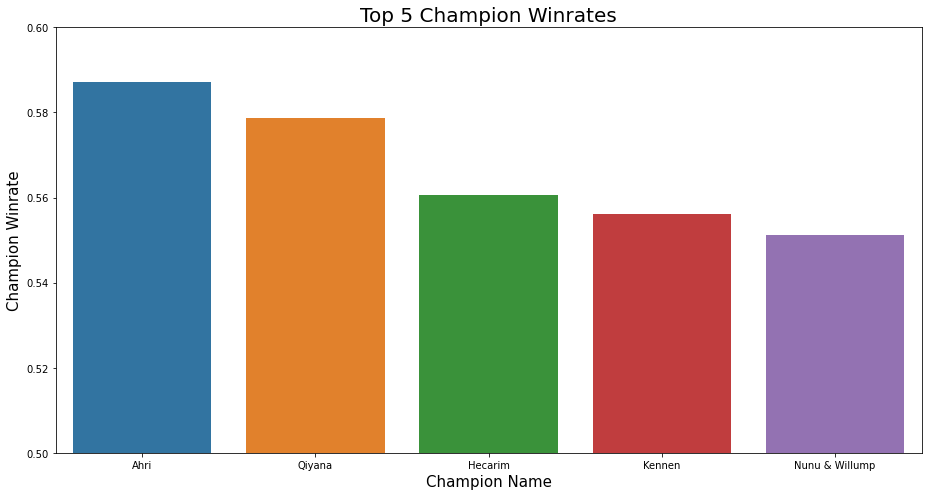

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (13,7))
to_plot = rates_df.sort_values('winrates', ascending = False).reset_index()[:5]

sns.barplot(data = to_plot, x = 'index', y = 'winrates', ax = ax)

ax.set_title('Top 5 Champion Winrates', fontsize = 20)
ax.set_xlabel('Champion Name', fontsize = 15)
ax.set_ylabel('Champion Winrate', fontsize = 15)
ax.set_ylim(0.5, 0.6)

fig.tight_layout()

plt.savefig('../Images/top_5_winrate.jpeg')

Now let's look at the pickrates.

In [82]:
rates_df.sort_values('pickrates', ascending = False)

,winrates,pickrates
Ezreal,0.497130,0.264500
Miss Fortune,0.515101,0.244660
Lee Sin,0.482964,0.237676
Thresh,0.498285,0.236056
Sett,0.499564,0.232007
...,...,...
Teemo,0.432990,0.009819
Annie,0.506024,0.008402
Udyr,0.506329,0.007997
Vi,0.455696,0.007997


In [83]:
rates_df['pickrates'].mean()

0.06756756756756757

It seems that many champions are hardly ever picked. We'll make a new plot of highest winrates using only The most relevant champions.

In [84]:
relevants_df = rates_df.loc[rates_df['pickrates'] >= 0.067]

In [85]:
relevants_df.sort_values('winrates', ascending = False)[:5]

,winrates,pickrates
Wukong,0.548830,0.125418
Katarina,0.543624,0.075412
Rek'Sai,0.539001,0.115498
Rakan,0.533133,0.100820
Draven,0.532258,0.087863


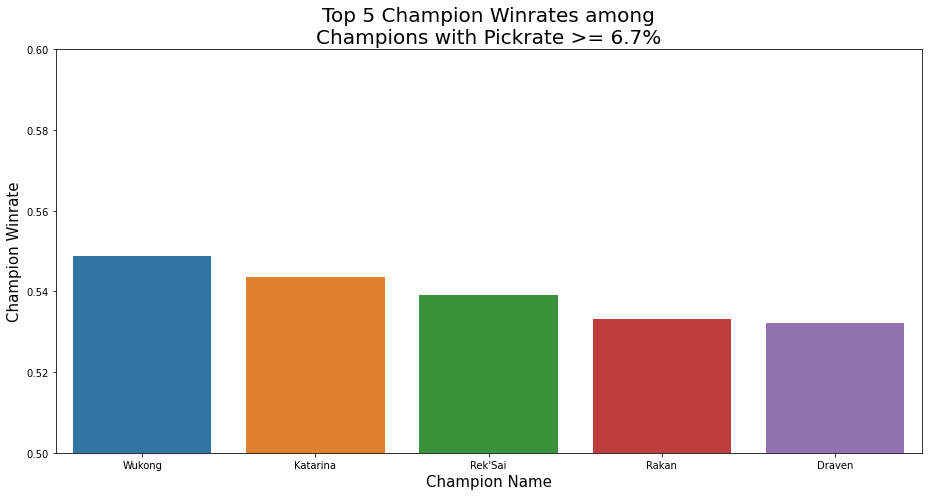

In [86]:
fig, ax = plt.subplots(figsize = (13,7))
to_plot = relevants_df.sort_values('winrates', ascending = False).reset_index()[:5]

sns.barplot(data = to_plot, x = 'index', y = 'winrates', ax = ax)

ax.set_title('Top 5 Champion Winrates among\nChampions with Pickrate >= 6.7%', fontsize = 20)
ax.set_xlabel('Champion Name', fontsize = 15)
ax.set_ylabel('Champion Winrate', fontsize = 15)
ax.set_ylim(0.5, 0.6)

fig.tight_layout()

plt.savefig('../Images/top_5_relevant.jpeg')

We want to add data to our dataframe concering the most impactful champions. For a champion to be impactful, it needs to be both decently popular (high pickrate) and have either a very high or very low winrate.

We'll make a new column called `impact` that takes the geometric mean of pickrate and the difference between the winrate and 50%.

In [87]:
rates_df['impact'] = np.sqrt(abs(0.5 - rates_df['winrates'])*rates_df['pickrates'])

In [88]:
rates_df.sort_values('impact', ascending = False)

,winrates,pickrates,impact
Wukong,0.548830,0.125418,0.078257
Nautilus,0.460712,0.150724,0.076952
Kai'Sa,0.470927,0.193238,0.074953
Irelia,0.454234,0.118332,0.073590
Sylas,0.464465,0.141006,0.070786
...,...,...,...
Kayle,0.502075,0.024395,0.007114
Annie,0.506024,0.008402,0.007114
Evelynn,0.501845,0.027432,0.007114
Skarner,0.500000,0.014576,0.000000


Now let's make a plot of this.

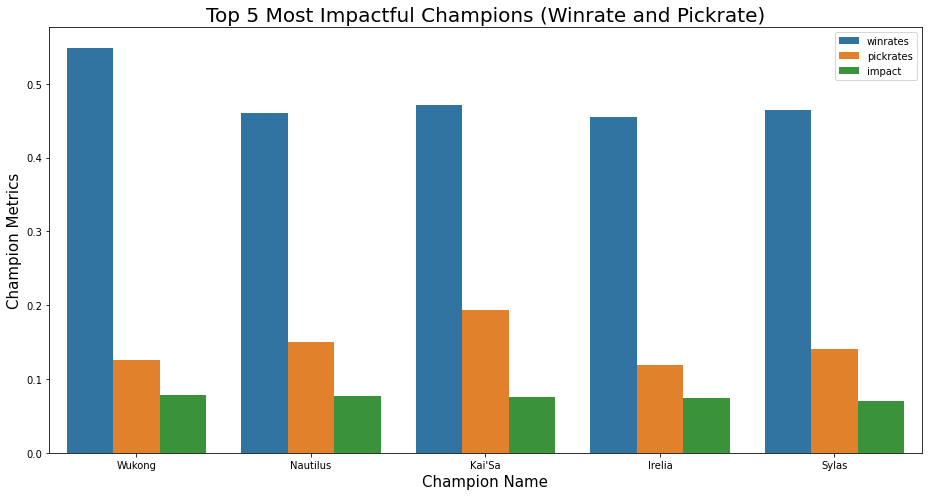

In [89]:
fig, ax = plt.subplots(figsize = (13,7))
to_plot = rates_df.sort_values('impact', ascending = False).stack().reset_index()[:15]

sns.barplot(data = to_plot, x = 'level_0', y = 0, hue = 'level_1')

ax.set_title('Top 5 Most Impactful Champions (Winrate and Pickrate)', fontsize = 20)
ax.set_xlabel('Champion Name', fontsize = 15)
ax.set_ylabel('Champion Metrics', fontsize = 15)

ax.legend()
fig.tight_layout()

plt.savefig('../Images/top_5_impact.jpeg')

We create a list of the most impactful champions.

In [90]:
most_impact = ['Wukong','Nautilus','Kai\'Sa','Irelia','Sylas']

Now, we use this list to create new columns in our dataframe that report whether or not each team has these five champions.

In [91]:
for champ in most_impact:
    df['blueHas'+str(champ)] = df['blueChamps'].map(lambda x: champ in x).astype(int)
    df['redHas'+str(champ)] = df['redChamps'].map(lambda x: champ in x).astype(int)

In [92]:
df.head()

,gameId,blueWins,blueVisionScore,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redVisionScore,redWardsDestroyed,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalExperience,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueChamps,redChamps,blueAvgWinrate,redAvgWinrate,blueAvgPickrate,redAvgPickrate,blueHasWukong,redHasWukong,blueHasNautilus,redHasNautilus,blueHasKai'Sa,redHasKai'Sa,blueHasIrelia,redHasIrelia,blueHasSylas,redHasSylas
0,4519157822,0,28,2,1,9,11,0,0,0,6.6,17039,36,643,-8,19.5,1721.0,15,6,6,8,0,0,0,6.8,17047,55,19.7,1656.7,"[Nautilus, Talon, Lucian, Nidalee, Malphite]","[Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]",0.489394,0.509859,0.086790,0.103614,0,0,1,0,0,0,0,0,0,0
1,4523371949,0,12,1,0,5,5,0,0,0,6.6,16265,43,-2908,-1173,17.4,1471.2,12,1,5,2,1,1,1,6.8,17438,52,24.0,1762.0,"[Twisted Fate, Yuumi, Nasus, Kai'Sa, Sett]","[Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]",0.492787,0.492763,0.124203,0.121591,0,0,0,0,1,0,0,1,0,0
2,4521474530,0,15,0,0,7,4,1,0,0,6.4,16221,46,-1172,-1033,18.6,1611.3,15,3,11,14,0,0,0,6.8,17254,28,20.3,1728.5,"[Rek'Sai, Akali, Lucian, Karma, Veigar]","[Kai'Sa, Zac, Riven, Syndra, Tahm Kench]",0.489751,0.498580,0.086608,0.112683,0,0,0,0,0,1,0,0,0,0
3,4524384067,0,43,1,0,4,5,0,1,0,7.0,17954,55,-1321,-7,20.1,1515.7,15,2,5,10,0,0,0,7.0,17961,47,23.5,1647.8,"[Lee Sin, Syndra, Ornn, Bard, Kalista]","[Varus, Thresh, Renekton, Ekko, Zed]",0.501475,0.508625,0.162425,0.144974,0,0,0,0,0,0,0,0,0,0
4,4436033771,0,75,4,0,6,6,0,0,0,7.0,18543,57,-1004,230,21.0,1640.0,17,2,6,7,1,0,0,7.0,18313,67,22.5,1740.4,"[Xerath, Aatrox, Ekko, Zyra, Miss Fortune]","[Caitlyn, Garen, Cassiopeia, Senna, Amumu]",0.494971,0.511632,0.122280,0.077761,0,0,0,0,0,0,0,0,0,0


### Adding Role Data
Recall the `champions_data` dataframe.

In [93]:
champions_data

,champions
0,"[(1, 100, 111, 'DUO_SUPPORT', 'BOTTOM'), (2, 1..."
1,"[(1, 100, 4, 'DUO_SUPPORT', 'NONE'), (2, 100, ..."
2,"[(1, 100, 421, 'NONE', 'JUNGLE'), (2, 100, 84,..."
3,"[(1, 100, 64, 'NONE', 'JUNGLE'), (2, 100, 134,..."
4,"[(1, 100, 101, 'DUO', 'TOP'), (2, 100, 266, 'D..."
...,...
9874,"[(1, 100, 21, 'DUO_CARRY', 'BOTTOM'), (2, 100,..."
9875,"[(1, 100, 432, 'DUO_SUPPORT', 'BOTTOM'), (2, 1..."
9876,"[(1, 100, 145, 'DUO_CARRY', 'BOTTOM'), (2, 100..."
9877,"[(1, 100, 38, 'DUO', 'MIDDLE'), (2, 100, 24, '..."


Let's parse this to get just the lanes.

In [94]:
sample = champions_data['champions'].iloc[0]

In [95]:
sample

"[(1, 100, 111, 'DUO_SUPPORT', 'BOTTOM'), (2, 100, 91, 'SOLO', 'MIDDLE'), (3, 100, 236, 'DUO_CARRY', 'BOTTOM'), (4, 100, 76, 'NONE', 'JUNGLE'), (5, 100, 54, 'SOLO', 'TOP'), (6, 200, 26, 'DUO_CARRY', 'BOTTOM'), (7, 200, 235, 'DUO_SUPPORT', 'BOTTOM'), (8, 200, 82, 'SOLO', 'TOP'), (9, 200, 421, 'NONE', 'JUNGLE'), (10, 200, 69, 'SOLO', 'MIDDLE')]"

First, we need to get just the lanes, ignoring punctuation.

In [96]:
mess = sample.strip('][').split(', ')[4::5]

In [97]:
mess

["'BOTTOM')",
 "'MIDDLE')",
 "'BOTTOM')",
 "'JUNGLE')",
 "'TOP')",
 "'BOTTOM')",
 "'BOTTOM')",
 "'TOP')",
 "'JUNGLE')",
 "'MIDDLE')"]

Now, we remove the punctuation issues.

In [98]:
cleaned = [lane.strip("')'") for lane in mess]

In [99]:
cleaned

['BOTTOM',
 'MIDDLE',
 'BOTTOM',
 'JUNGLE',
 'TOP',
 'BOTTOM',
 'BOTTOM',
 'TOP',
 'JUNGLE',
 'MIDDLE']

We put this process in a function and apply it to the datamframe to get a list of roles.

In [100]:
def make_roles(champlist):
    mess = champlist.strip('][').split(', ')[4::5]
    cleaned = [lane.strip("')'") for lane in mess]
    return cleaned

In [101]:
df['roles'] = champions_data['champions'].map(make_roles)

In [102]:
df.head()

,gameId,blueWins,blueVisionScore,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redVisionScore,redWardsDestroyed,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalExperience,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueChamps,redChamps,blueAvgWinrate,redAvgWinrate,blueAvgPickrate,redAvgPickrate,blueHasWukong,redHasWukong,blueHasNautilus,redHasNautilus,blueHasKai'Sa,redHasKai'Sa,blueHasIrelia,redHasIrelia,blueHasSylas,redHasSylas,roles
0,4519157822,0,28,2,1,9,11,0,0,0,6.6,17039,36,643,-8,19.5,1721.0,15,6,6,8,0,0,0,6.8,17047,55,19.7,1656.7,"[Nautilus, Talon, Lucian, Nidalee, Malphite]","[Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]",0.489394,0.509859,0.086790,0.103614,0,0,1,0,0,0,0,0,0,0,"[BOTTOM, MIDDLE, BOTTOM, JUNGLE, TOP, BOTTOM, ..."
1,4523371949,0,12,1,0,5,5,0,0,0,6.6,16265,43,-2908,-1173,17.4,1471.2,12,1,5,2,1,1,1,6.8,17438,52,24.0,1762.0,"[Twisted Fate, Yuumi, Nasus, Kai'Sa, Sett]","[Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]",0.492787,0.492763,0.124203,0.121591,0,0,0,0,1,0,0,1,0,0,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON..."
2,4521474530,0,15,0,0,7,4,1,0,0,6.4,16221,46,-1172,-1033,18.6,1611.3,15,3,11,14,0,0,0,6.8,17254,28,20.3,1728.5,"[Rek'Sai, Akali, Lucian, Karma, Veigar]","[Kai'Sa, Zac, Riven, Syndra, Tahm Kench]",0.489751,0.498580,0.086608,0.112683,0,0,0,0,0,1,0,0,0,0,"[JUNGLE, TOP, BOTTOM, BOTTOM, MIDDLE, BOTTOM, ..."
3,4524384067,0,43,1,0,4,5,0,1,0,7.0,17954,55,-1321,-7,20.1,1515.7,15,2,5,10,0,0,0,7.0,17961,47,23.5,1647.8,"[Lee Sin, Syndra, Ornn, Bard, Kalista]","[Varus, Thresh, Renekton, Ekko, Zed]",0.501475,0.508625,0.162425,0.144974,0,0,0,0,0,0,0,0,0,0,"[JUNGLE, MIDDLE, TOP, BOTTOM, BOTTOM, BOTTOM, ..."
4,4436033771,0,75,4,0,6,6,0,0,0,7.0,18543,57,-1004,230,21.0,1640.0,17,2,6,7,1,0,0,7.0,18313,67,22.5,1740.4,"[Xerath, Aatrox, Ekko, Zyra, Miss Fortune]","[Caitlyn, Garen, Cassiopeia, Senna, Amumu]",0.494971,0.511632,0.122280,0.077761,0,0,0,0,0,0,0,0,0,0,"[TOP, TOP, JUNGLE, BOTTOM, BOTTOM, BOTTOM, TOP..."


Let's split this into `blueRoles` and `redRoles`

In [103]:
df['blueRoles'] = df['roles'].map(lambda x: x[:5])

In [104]:
df['redRoles'] = df['roles'].map(lambda x: x[5:])

In [105]:
df.head()

,gameId,blueWins,blueVisionScore,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redVisionScore,redWardsDestroyed,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalExperience,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueChamps,redChamps,blueAvgWinrate,redAvgWinrate,blueAvgPickrate,redAvgPickrate,blueHasWukong,redHasWukong,blueHasNautilus,redHasNautilus,blueHasKai'Sa,redHasKai'Sa,blueHasIrelia,redHasIrelia,blueHasSylas,redHasSylas,roles,blueRoles,redRoles
0,4519157822,0,28,2,1,9,11,0,0,0,6.6,17039,36,643,-8,19.5,1721.0,15,6,6,8,0,0,0,6.8,17047,55,19.7,1656.7,"[Nautilus, Talon, Lucian, Nidalee, Malphite]","[Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]",0.489394,0.509859,0.086790,0.103614,0,0,1,0,0,0,0,0,0,0,"[BOTTOM, MIDDLE, BOTTOM, JUNGLE, TOP, BOTTOM, ...","[BOTTOM, MIDDLE, BOTTOM, JUNGLE, TOP]","[BOTTOM, BOTTOM, TOP, JUNGLE, MIDDLE]"
1,4523371949,0,12,1,0,5,5,0,0,0,6.6,16265,43,-2908,-1173,17.4,1471.2,12,1,5,2,1,1,1,6.8,17438,52,24.0,1762.0,"[Twisted Fate, Yuumi, Nasus, Kai'Sa, Sett]","[Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]",0.492787,0.492763,0.124203,0.121591,0,0,0,0,1,0,0,1,0,0,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[NONE, NONE, NONE, NONE, NONE]","[NONE, NONE, NONE, NONE, NONE]"
2,4521474530,0,15,0,0,7,4,1,0,0,6.4,16221,46,-1172,-1033,18.6,1611.3,15,3,11,14,0,0,0,6.8,17254,28,20.3,1728.5,"[Rek'Sai, Akali, Lucian, Karma, Veigar]","[Kai'Sa, Zac, Riven, Syndra, Tahm Kench]",0.489751,0.498580,0.086608,0.112683,0,0,0,0,0,1,0,0,0,0,"[JUNGLE, TOP, BOTTOM, BOTTOM, MIDDLE, BOTTOM, ...","[JUNGLE, TOP, BOTTOM, BOTTOM, MIDDLE]","[BOTTOM, JUNGLE, TOP, MIDDLE, BOTTOM]"
3,4524384067,0,43,1,0,4,5,0,1,0,7.0,17954,55,-1321,-7,20.1,1515.7,15,2,5,10,0,0,0,7.0,17961,47,23.5,1647.8,"[Lee Sin, Syndra, Ornn, Bard, Kalista]","[Varus, Thresh, Renekton, Ekko, Zed]",0.501475,0.508625,0.162425,0.144974,0,0,0,0,0,0,0,0,0,0,"[JUNGLE, MIDDLE, TOP, BOTTOM, BOTTOM, BOTTOM, ...","[JUNGLE, MIDDLE, TOP, BOTTOM, BOTTOM]","[BOTTOM, BOTTOM, TOP, JUNGLE, MIDDLE]"
4,4436033771,0,75,4,0,6,6,0,0,0,7.0,18543,57,-1004,230,21.0,1640.0,17,2,6,7,1,0,0,7.0,18313,67,22.5,1740.4,"[Xerath, Aatrox, Ekko, Zyra, Miss Fortune]","[Caitlyn, Garen, Cassiopeia, Senna, Amumu]",0.494971,0.511632,0.122280,0.077761,0,0,0,0,0,0,0,0,0,0,"[TOP, TOP, JUNGLE, BOTTOM, BOTTOM, BOTTOM, TOP...","[TOP, TOP, JUNGLE, BOTTOM, BOTTOM]","[BOTTOM, TOP, MIDDLE, BOTTOM, JUNGLE]"


Let's make a boolean that defines wheter or not each team has a 'conventional' team composition (2 bottom, 1 top, 1 middle, 1 jungle).

In [106]:
def make_conventional(roles):
    bot = 0
    mid = 0
    jung = 0
    top = 0
    for role in roles:
        if role == 'BOTTOM':
            bot += 1
        elif role == 'MIDDLE':
            mid += 1
        elif role == 'JUNGLE':
            jung += 1
        elif role == 'TOP':
            top += 1
    if (bot == 2) and (mid == 1) and (jung == 1) and (top == 1):
        return 1
    return 0

In [107]:
df['blueConventional'] = df['blueRoles'].map(make_conventional)
df['redConventional'] = df['redRoles'].map(make_conventional)

We also add a simple count of each lane to the dataframe.

In [108]:
df['blueBottoms'] = df['blueRoles'].map(lambda x: x.count('BOTTOM'))
df['blueMiddles'] = df['blueRoles'].map(lambda x: x.count('MIDDLE'))
df['blueTops'] = df['blueRoles'].map(lambda x: x.count('TOP'))
df['blueJungles'] = df['blueRoles'].map(lambda x: x.count('JUNGLE'))

df['redBottoms'] = df['redRoles'].map(lambda x: x.count('BOTTOM'))
df['redMiddles'] = df['redRoles'].map(lambda x: x.count('MIDDLE'))
df['redTops'] = df['redRoles'].map(lambda x: x.count('TOP'))
df['redJungles'] = df['redRoles'].map(lambda x: x.count('JUNGLE'))

In [109]:
df.head()

,gameId,blueWins,blueVisionScore,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redVisionScore,redWardsDestroyed,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalExperience,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueChamps,redChamps,blueAvgWinrate,redAvgWinrate,blueAvgPickrate,redAvgPickrate,blueHasWukong,redHasWukong,blueHasNautilus,redHasNautilus,blueHasKai'Sa,redHasKai'Sa,blueHasIrelia,redHasIrelia,blueHasSylas,redHasSylas,roles,blueRoles,redRoles,blueConventional,redConventional,blueBottoms,blueMiddles,blueTops,blueJungles,redBottoms,redMiddles,redTops,redJungles
0,4519157822,0,28,2,1,9,11,0,0,0,6.6,17039,36,643,-8,19.5,1721.0,15,6,6,8,0,0,0,6.8,17047,55,19.7,1656.7,"[Nautilus, Talon, Lucian, Nidalee, Malphite]","[Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]",0.489394,0.509859,0.086790,0.103614,0,0,1,0,0,0,0,0,0,0,"[BOTTOM, MIDDLE, BOTTOM, JUNGLE, TOP, BOTTOM, ...","[BOTTOM, MIDDLE, BOTTOM, JUNGLE, TOP]","[BOTTOM, BOTTOM, TOP, JUNGLE, MIDDLE]",1,1,2,1,1,1,2,1,1,1
1,4523371949,0,12,1,0,5,5,0,0,0,6.6,16265,43,-2908,-1173,17.4,1471.2,12,1,5,2,1,1,1,6.8,17438,52,24.0,1762.0,"[Twisted Fate, Yuumi, Nasus, Kai'Sa, Sett]","[Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]",0.492787,0.492763,0.124203,0.121591,0,0,0,0,1,0,0,1,0,0,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[NONE, NONE, NONE, NONE, NONE]","[NONE, NONE, NONE, NONE, NONE]",0,0,0,0,0,0,0,0,0,0
2,4521474530,0,15,0,0,7,4,1,0,0,6.4,16221,46,-1172,-1033,18.6,1611.3,15,3,11,14,0,0,0,6.8,17254,28,20.3,1728.5,"[Rek'Sai, Akali, Lucian, Karma, Veigar]","[Kai'Sa, Zac, Riven, Syndra, Tahm Kench]",0.489751,0.498580,0.086608,0.112683,0,0,0,0,0,1,0,0,0,0,"[JUNGLE, TOP, BOTTOM, BOTTOM, MIDDLE, BOTTOM, ...","[JUNGLE, TOP, BOTTOM, BOTTOM, MIDDLE]","[BOTTOM, JUNGLE, TOP, MIDDLE, BOTTOM]",1,1,2,1,1,1,2,1,1,1
3,4524384067,0,43,1,0,4,5,0,1,0,7.0,17954,55,-1321,-7,20.1,1515.7,15,2,5,10,0,0,0,7.0,17961,47,23.5,1647.8,"[Lee Sin, Syndra, Ornn, Bard, Kalista]","[Varus, Thresh, Renekton, Ekko, Zed]",0.501475,0.508625,0.162425,0.144974,0,0,0,0,0,0,0,0,0,0,"[JUNGLE, MIDDLE, TOP, BOTTOM, BOTTOM, BOTTOM, ...","[JUNGLE, MIDDLE, TOP, BOTTOM, BOTTOM]","[BOTTOM, BOTTOM, TOP, JUNGLE, MIDDLE]",1,1,2,1,1,1,2,1,1,1
4,4436033771,0,75,4,0,6,6,0,0,0,7.0,18543,57,-1004,230,21.0,1640.0,17,2,6,7,1,0,0,7.0,18313,67,22.5,1740.4,"[Xerath, Aatrox, Ekko, Zyra, Miss Fortune]","[Caitlyn, Garen, Cassiopeia, Senna, Amumu]",0.494971,0.511632,0.122280,0.077761,0,0,0,0,0,0,0,0,0,0,"[TOP, TOP, JUNGLE, BOTTOM, BOTTOM, BOTTOM, TOP...","[TOP, TOP, JUNGLE, BOTTOM, BOTTOM]","[BOTTOM, TOP, MIDDLE, BOTTOM, JUNGLE]",0,1,2,0,2,1,2,1,1,1


## Levels Data
### API Calls
Recall the `gameids` series.

In [110]:
gameids

0       4519157822
1       4523371949
2       4521474530
3       4524384067
4       4436033771
           ...    
9874    4527873286
9875    4527797466
9876    4527713716
9877    4527628313
9878    4523772935
Name: gameId, Length: 9879, dtype: int64

We used this again to get levels for each team at the 10 minute mark. Again, the cell below takes a long time to run and requres an API key. So, for this notebook, we'll just import the data from previous calls.

In [111]:
# champ_levels_list = []
# count = 0
# for id_ in gameids:
#     count += 1
#     print(count, end = ', ')
#     while 1:
#         try:
#             url = f'https://euw1.api.riotgames.com/lol/match/v4/timelines/by-match/{id_}?api_key=YOUR-KEY-HERE'
#             got = requests.get(url)
#             timeline = json.loads(got.text)
#             sleep(1.2)

#             frames = timeline['frames'][:11]
#             break
#         except:
#             pass
    
#     final = frames[-1]['participantFrames']
#     levels = {i:None for i in range(1, 11)}
    
#     for participant in final.values():
#         levels[participant['participantId']] = participant['level']
    
#     champ_levels_list.append(levels)

In [112]:
levels = pd.read_csv('../archive/items-levels.csv').drop(['Unnamed: 0','items'], axis = 1)
levels

,levels
0,"{1: 5, 2: 7, 3: 7, 4: 7, 5: 7, 6: 6, 7: 6, 8: ..."
1,"{1: 7, 2: 5, 3: 8, 4: 6, 5: 7, 6: 6, 7: 7, 8: ..."
2,"{1: 6, 2: 8, 3: 5, 4: 6, 5: 7, 6: 6, 7: 6, 8: ..."
3,"{1: 7, 2: 8, 3: 7, 4: 7, 5: 6, 6: 6, 7: 6, 8: ..."
4,"{1: 8, 2: 8, 3: 7, 4: 5, 5: 7, 6: 6, 7: 8, 8: ..."
...,...
9874,"{1: 7, 2: 8, 3: 7, 4: 8, 5: 6, 6: 6, 7: 6, 8: ..."
9875,"{1: 7, 2: 6, 3: 8, 4: 8, 5: 7, 6: 7, 7: 8, 8: ..."
9876,"{1: 7, 2: 8, 3: 6, 4: 7, 5: 7, 6: 8, 7: 6, 8: ..."
9877,"{1: 8, 2: 7, 3: 6, 4: 6, 5: 6, 6: 8, 7: 7, 8: ..."


As these are also strings, they must be parsed.

In [113]:
sample = levels['levels'].iloc[0]

In [114]:
sample

'{1: 5, 2: 7, 3: 7, 4: 7, 5: 7, 6: 6, 7: 6, 8: 7, 9: 7, 10: 8}'

First, we split by `', '`, which will give us the dictionary elements as strings.

In [115]:
sample = sample.split(', ')
sample

['{1: 5',
 '2: 7',
 '3: 7',
 '4: 7',
 '5: 7',
 '6: 6',
 '7: 6',
 '8: 7',
 '9: 7',
 '10: 8}']

Now, we strip away the curly brackets and split each element by `: ` and take what comes after this. We want the values of this dictionary. The keys are simply the participantIDs for the game. The values are actually the levels at the 10 minute mark.

In [116]:
sample = [x.strip('}{') for x in sample]
sample

['1: 5',
 '2: 7',
 '3: 7',
 '4: 7',
 '5: 7',
 '6: 6',
 '7: 6',
 '8: 7',
 '9: 7',
 '10: 8']

In [117]:
sample = [int(x.split(': ')[1]) for x in sample]
sample

[5, 7, 7, 7, 7, 6, 6, 7, 7, 8]

We'll now add this preprocessing to a function and apply it to the `levels` dataframe.

In [118]:
def to_levels(mess):
    split = mess.split(', ')
    stripped = [x.strip('}{') for x in split]
    clean = [int(x.split(': ')[1]) for x in stripped]
    
    return clean

In [119]:
levels['levels'] = levels['levels'].map(to_levels)
levels.head()

,levels
0,"[5, 7, 7, 7, 7, 6, 6, 7, 7, 8]"
1,"[7, 5, 8, 6, 7, 6, 7, 5, 8, 8]"
2,"[6, 8, 5, 6, 7, 6, 6, 8, 8, 6]"
3,"[7, 8, 7, 7, 6, 6, 6, 8, 7, 8]"
4,"[8, 8, 7, 5, 7, 6, 8, 8, 6, 7]"


Now, we split this into `blueLevels` and `redLevels`.

In [120]:
levels['blueLevels'] = levels['levels'].map(lambda x: x[:5])
levels['redLevels'] = levels['levels'].map(lambda x: x[5:])
levels.head()

,levels,blueLevels,redLevels
0,"[5, 7, 7, 7, 7, 6, 6, 7, 7, 8]","[5, 7, 7, 7, 7]","[6, 6, 7, 7, 8]"
1,"[7, 5, 8, 6, 7, 6, 7, 5, 8, 8]","[7, 5, 8, 6, 7]","[6, 7, 5, 8, 8]"
2,"[6, 8, 5, 6, 7, 6, 6, 8, 8, 6]","[6, 8, 5, 6, 7]","[6, 6, 8, 8, 6]"
3,"[7, 8, 7, 7, 6, 6, 6, 8, 7, 8]","[7, 8, 7, 7, 6]","[6, 6, 8, 7, 8]"
4,"[8, 8, 7, 5, 7, 6, 8, 8, 6, 7]","[8, 8, 7, 5, 7]","[6, 8, 8, 6, 7]"


Finall, we add some descriptive statistis to the dataframe. Namely, we use the `min`, `max`, and `std` (standard deviation) of each list of levels for each team.

In [121]:
levels['blueMaxLevel'] = levels['blueLevels'].map(max)
levels['blueMinLevel'] = levels['blueLevels'].map(min)
levels['blueSTDLevels'] = levels['blueLevels'].map(np.std)

levels['redMaxLevel'] = levels['redLevels'].map(max)
levels['redMinLevel'] = levels['redLevels'].map(min)
levels['redSTDLevels'] = levels['redLevels'].map(np.std)

levels.head()

,levels,blueLevels,redLevels,blueMaxLevel,blueMinLevel,blueSTDLevels,redMaxLevel,redMinLevel,redSTDLevels
0,"[5, 7, 7, 7, 7, 6, 6, 7, 7, 8]","[5, 7, 7, 7, 7]","[6, 6, 7, 7, 8]",7,5,0.800000,8,6,0.748331
1,"[7, 5, 8, 6, 7, 6, 7, 5, 8, 8]","[7, 5, 8, 6, 7]","[6, 7, 5, 8, 8]",8,5,1.019804,8,5,1.166190
2,"[6, 8, 5, 6, 7, 6, 6, 8, 8, 6]","[6, 8, 5, 6, 7]","[6, 6, 8, 8, 6]",8,5,1.019804,8,6,0.979796
3,"[7, 8, 7, 7, 6, 6, 6, 8, 7, 8]","[7, 8, 7, 7, 6]","[6, 6, 8, 7, 8]",8,6,0.632456,8,6,0.894427
4,"[8, 8, 7, 5, 7, 6, 8, 8, 6, 7]","[8, 8, 7, 5, 7]","[6, 8, 8, 6, 7]",8,5,1.095445,8,6,0.894427


We drop the list columns, keeping the destriptive statistics.

In [122]:
levels.drop(['levels','blueLevels','redLevels'], axis = 1, inplace = True)
levels.head()

,blueMaxLevel,blueMinLevel,blueSTDLevels,redMaxLevel,redMinLevel,redSTDLevels
0,7,5,0.800000,8,6,0.748331
1,8,5,1.019804,8,5,1.166190
2,8,5,1.019804,8,6,0.979796
3,8,6,0.632456,8,6,0.894427
4,8,5,1.095445,8,6,0.894427


Now, we add these to the dataframe.

In [123]:
df = pd.concat([df,levels], axis = 1)

In [124]:
df.head()

,gameId,blueWins,blueVisionScore,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redVisionScore,redWardsDestroyed,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalExperience,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueChamps,redChamps,blueAvgWinrate,redAvgWinrate,blueAvgPickrate,redAvgPickrate,blueHasWukong,redHasWukong,blueHasNautilus,redHasNautilus,blueHasKai'Sa,redHasKai'Sa,blueHasIrelia,redHasIrelia,blueHasSylas,redHasSylas,roles,blueRoles,redRoles,blueConventional,redConventional,blueBottoms,blueMiddles,blueTops,blueJungles,redBottoms,redMiddles,redTops,redJungles,blueMaxLevel,blueMinLevel,blueSTDLevels,redMaxLevel,redMinLevel,redSTDLevels
0,4519157822,0,28,2,1,9,11,0,0,0,6.6,17039,36,643,-8,19.5,1721.0,15,6,6,8,0,0,0,6.8,17047,55,19.7,1656.7,"[Nautilus, Talon, Lucian, Nidalee, Malphite]","[Zilean, Senna, Mordekaiser, Rek'Sai, Cassiopeia]",0.489394,0.509859,0.086790,0.103614,0,0,1,0,0,0,0,0,0,0,"[BOTTOM, MIDDLE, BOTTOM, JUNGLE, TOP, BOTTOM, ...","[BOTTOM, MIDDLE, BOTTOM, JUNGLE, TOP]","[BOTTOM, BOTTOM, TOP, JUNGLE, MIDDLE]",1,1,2,1,1,1,2,1,1,1,7,5,0.800000,8,6,0.748331
1,4523371949,0,12,1,0,5,5,0,0,0,6.6,16265,43,-2908,-1173,17.4,1471.2,12,1,5,2,1,1,1,6.8,17438,52,24.0,1762.0,"[Twisted Fate, Yuumi, Nasus, Kai'Sa, Sett]","[Varus, Jarvan IV, Blitzcrank, Syndra, Irelia]",0.492787,0.492763,0.124203,0.121591,0,0,0,0,1,0,0,1,0,0,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[NONE, NONE, NONE, NONE, NONE]","[NONE, NONE, NONE, NONE, NONE]",0,0,0,0,0,0,0,0,0,0,8,5,1.019804,8,5,1.166190
2,4521474530,0,15,0,0,7,4,1,0,0,6.4,16221,46,-1172,-1033,18.6,1611.3,15,3,11,14,0,0,0,6.8,17254,28,20.3,1728.5,"[Rek'Sai, Akali, Lucian, Karma, Veigar]","[Kai'Sa, Zac, Riven, Syndra, Tahm Kench]",0.489751,0.498580,0.086608,0.112683,0,0,0,0,0,1,0,0,0,0,"[JUNGLE, TOP, BOTTOM, BOTTOM, MIDDLE, BOTTOM, ...","[JUNGLE, TOP, BOTTOM, BOTTOM, MIDDLE]","[BOTTOM, JUNGLE, TOP, MIDDLE, BOTTOM]",1,1,2,1,1,1,2,1,1,1,8,5,1.019804,8,6,0.979796
3,4524384067,0,43,1,0,4,5,0,1,0,7.0,17954,55,-1321,-7,20.1,1515.7,15,2,5,10,0,0,0,7.0,17961,47,23.5,1647.8,"[Lee Sin, Syndra, Ornn, Bard, Kalista]","[Varus, Thresh, Renekton, Ekko, Zed]",0.501475,0.508625,0.162425,0.144974,0,0,0,0,0,0,0,0,0,0,"[JUNGLE, MIDDLE, TOP, BOTTOM, BOTTOM, BOTTOM, ...","[JUNGLE, MIDDLE, TOP, BOTTOM, BOTTOM]","[BOTTOM, BOTTOM, TOP, JUNGLE, MIDDLE]",1,1,2,1,1,1,2,1,1,1,8,6,0.632456,8,6,0.894427
4,4436033771,0,75,4,0,6,6,0,0,0,7.0,18543,57,-1004,230,21.0,1640.0,17,2,6,7,1,0,0,7.0,18313,67,22.5,1740.4,"[Xerath, Aatrox, Ekko, Zyra, Miss Fortune]","[Caitlyn, Garen, Cassiopeia, Senna, Amumu]",0.494971,0.511632,0.122280,0.077761,0,0,0,0,0,0,0,0,0,0,"[TOP, TOP, JUNGLE, BOTTOM, BOTTOM, BOTTOM, TOP...","[TOP, TOP, JUNGLE, BOTTOM, BOTTOM]","[BOTTOM, TOP, MIDDLE, BOTTOM, JUNGLE]",0,1,2,0,2,1,2,1,1,1,8,5,1.095445,8,6,0.894427


Finally, we'll drop any data from the dataframe that is not numeric (currently, many of the dataframe items are lists).

In [125]:
df.drop(['blueChamps','redChamps','roles','blueRoles','redRoles'], axis = 1, inplace = True)

A final peak at our dataframe will confirm that all of our added numeric data remains, whilst all of the unusable (list) data is gone.

In [126]:
df.head()

,gameId,blueWins,blueVisionScore,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redVisionScore,redWardsDestroyed,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalExperience,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueAvgWinrate,redAvgWinrate,blueAvgPickrate,redAvgPickrate,blueHasWukong,redHasWukong,blueHasNautilus,redHasNautilus,blueHasKai'Sa,redHasKai'Sa,blueHasIrelia,redHasIrelia,blueHasSylas,redHasSylas,blueConventional,redConventional,blueBottoms,blueMiddles,blueTops,blueJungles,redBottoms,redMiddles,redTops,redJungles,blueMaxLevel,blueMinLevel,blueSTDLevels,redMaxLevel,redMinLevel,redSTDLevels
0,4519157822,0,28,2,1,9,11,0,0,0,6.6,17039,36,643,-8,19.5,1721.0,15,6,6,8,0,0,0,6.8,17047,55,19.7,1656.7,0.489394,0.509859,0.086790,0.103614,0,0,1,0,0,0,0,0,0,0,1,1,2,1,1,1,2,1,1,1,7,5,0.800000,8,6,0.748331
1,4523371949,0,12,1,0,5,5,0,0,0,6.6,16265,43,-2908,-1173,17.4,1471.2,12,1,5,2,1,1,1,6.8,17438,52,24.0,1762.0,0.492787,0.492763,0.124203,0.121591,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,8,5,1.019804,8,5,1.166190
2,4521474530,0,15,0,0,7,4,1,0,0,6.4,16221,46,-1172,-1033,18.6,1611.3,15,3,11,14,0,0,0,6.8,17254,28,20.3,1728.5,0.489751,0.498580,0.086608,0.112683,0,0,0,0,0,1,0,0,0,0,1,1,2,1,1,1,2,1,1,1,8,5,1.019804,8,6,0.979796
3,4524384067,0,43,1,0,4,5,0,1,0,7.0,17954,55,-1321,-7,20.1,1515.7,15,2,5,10,0,0,0,7.0,17961,47,23.5,1647.8,0.501475,0.508625,0.162425,0.144974,0,0,0,0,0,0,0,0,0,0,1,1,2,1,1,1,2,1,1,1,8,6,0.632456,8,6,0.894427
4,4436033771,0,75,4,0,6,6,0,0,0,7.0,18543,57,-1004,230,21.0,1640.0,17,2,6,7,1,0,0,7.0,18313,67,22.5,1740.4,0.494971,0.511632,0.122280,0.077761,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,1,2,1,1,1,8,5,1.095445,8,6,0.894427


# Processing the Professional Dataset

In [151]:
df_2 = pd.read_csv("../archive/2021_LoL_esports_match_data_from_OraclesElixir_20210713.csv")

In [152]:
df_2.head()
# scoping it out

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,1,Blue,top,Khan,DWG KIA,Mordekaiser,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782,1,7,1,3,23,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,20435,688.0471,0.276268,717.7441,933.9731,13,0.4377,5,0.1684,7,25.0,0.8418,12065,8154,274.5455,0.196019,10875.0,NaN,209.0,193.0,16,8,5,7.0370,3421.0,5043.0,73.0,2985.0,4493.0,72.0,436.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5407.0,7536.0,114.0,4659.0,7592.0,118.0,748.0,-56.0,-4.0,2.0,0.0,1.0,0.0,1.0,1.0
1,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,2,Blue,jng,Canyon,DWG KIA,Graves,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782,1,7,1,5,23,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,13944,469.4949,0.188514,559.0909,400.5387,10,0.3367,14,0.4714,10,46.0,1.5488,13944,10033,337.8114,0.241189,13850.0,NaN,259.0,41.0,218,110,43,8.7205,3497.0,4314.0,87.0,3055.0,3059.0,62.0,442.0,1255.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,6974.0,8232.0,146.0,4854.0,4827.0,84.0,2120.0,3405.0,62.0,3.0,2.0,0.0,2.0,0.0,3.0
2,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,3,Blue,mid,ShowMaker,DWG KIA,Zoe,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782,1,5,0,8,23,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,16039,540.0337,0.216837,285.4545,282.6936,11,0.3704,8,0.2694,4,59.0,1.9865,14274,10363,348.9226,0.249122,12700.0,NaN,299.0,250.0,49,17,24,10.0673,3784.0,5171.0,114.0,3301.0,4822.0,91.0,483.0,349.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,6591.0,7827.0,158.0,5013.0,7473.0,143.0,1578.0,354.0,15.0,2.0,3.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,4,Blue,bot,Ghost,DWG KIA,Miss Fortune,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782,1,3,2,11,23,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,17202,579.1919,0.232560,339.6296,291.8855,15,0.5051,5,0.1684,7,34.0,1.1448,13097,9186,309.2929,0.220828,11925.0,NaN,292.0,265.0,27,17,4,9.8316,3540.0,3354.0,94.0,3020.0,3053.0,75.0,520.0,301.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,5202.0,5053.0,130.0,5078.0,4951.0,120.0,124.0,102.0,10.0,0.0,4.0,2.0,1.0,1.0,2.0
4,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leag

In [153]:
df_2 = df_2.drop(["goldat15", "xpat15", "csat15", "opp_goldat15", "opp_xpat15", "opp_csat15", "golddiffat15", 
                  "xpdiffat15", "csdiffat15", "killsat15", "assistsat15", "deathsat15", "opp_killsat15", 
                 "opp_assistsat15", "opp_deathsat15"], axis = 1)
df_2.head()
# droping obvious columns we won't be using

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10
0,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,1,Blue,top,Khan,DWG KIA,Mordekaiser,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782,1,7,1,3,23,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,20435,688.0471,0.276268,717.7441,933.9731,13,0.4377,5,0.1684,7,25.0,0.8418,12065,8154,274.5455,0.196019,10875.0,NaN,209.0,193.0,16,8,5,7.0370,3421.0,5043.0,73.0,2985.0,4493.0,72.0,436.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,2,Blue,jng,Canyon,DWG KIA,Graves,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782,1,7,1,5,23,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,13944,469.4949,0.188514,559.0909,400.5387,10,0.3367,14,0.4714,10,46.0,1.5488,13944,10033,337.8114,0.241189,13850.0,NaN,259.0,41.0,218,110,43,8.7205,3497.0,4314.0,87.0,3055.0,3059.0,62.0,442.0,1255.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,3,Blue,mid,ShowMaker,DWG KIA,Zoe,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782,1,5,0,8,23,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,16039,540.0337,0.216837,285.4545,282.6936,11,0.3704,8,0.2694,4,59.0,1.9865,14274,10363,348.9226,0.249122,12700.0,NaN,299.0,250.0,49,17,24,10.0673,3784.0,5171.0,114.0,3301.0,4822.0,91.0,483.0,349.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,4,Blue,bot,Ghost,DWG KIA,Miss Fortune,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782,1,3,2,11,23,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,17202,579.1919,0.232560,339.6296,291.8855,15,0.5051,5,0.1684,7,34.0,1.1448,13097,9186,309.2929,0.220828,11925.0,NaN,292.0,265.0,27,17,4,9.8316,3540.0,3354.0,94.0,3020.0,3053.0,75.0,520.0,301.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,5,Blue,sup,BeryL,DWG KIA,Galio,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782,1,1,0,14,23,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6348,213.7374,0.085821,267.8788,781.6162,53,1.7845,13,0.4377,16,90.0,3.0303,7773,3862,130.0337,0.092842,7000.0,NaN,37.0,37.0,0,0,0,1.2458,2049.0,2577.0,14.0,2137.0,2667.0,17.0,-88.0,-90.0,-3.0,0

In [154]:
df_2 = df_2.drop(["ban1", "ban2", "ban3", "ban4", "ban5", "kills", "deaths", "assists", "teamkills", "teamdeaths", 
                  "firstbaron", "barons", "opp_barons", "elders",  "datacompleteness", "year", "playerid"], axis = 1)
df_2.head()
# Still dropping columns

,gameid,url,league,split,playoffs,date,game,patch,side,position,player,team,champion,gamelength,result,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,dragons (type unknown),opp_elders,firstherald,heralds,opp_heralds,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10
0,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,top,Khan,DWG KIA,Mordekaiser,1782,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,20435,688.0471,0.276268,717.7441,933.9731,13,0.4377,5,0.1684,7,25.0,0.8418,12065,8154,274.5455,0.196019,10875.0,NaN,209.0,193.0,16,8,5,7.0370,3421.0,5043.0,73.0,2985.0,4493.0,72.0,436.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,jng,Canyon,DWG KIA,Graves,1782,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,13944,469.4949,0.188514,559.0909,400.5387,10,0.3367,14,0.4714,10,46.0,1.5488,13944,10033,337.8114,0.241189,13850.0,NaN,259.0,41.0,218,110,43,8.7205,3497.0,4314.0,87.0,3055.0,3059.0,62.0,442.0,1255.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,mid,ShowMaker,DWG KIA,Zoe,1782,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,16039,540.0337,0.216837,285.4545,282.6936,11,0.3704,8,0.2694,4,59.0,1.9865,14274,10363,348.9226,0.249122,12700.0,NaN,299.0,250.0,49,17,24,10.0673,3784.0,5171.0,114.0,3301.0,4822.0,91.0,483.0,349.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,bot,Ghost,DWG KIA,Miss Fortune,1782,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,17202,579.1919,0.232560,339.6296,291.8855,15,0.5051,5,0.1684,7,34.0,1.1448,13097,9186,309.2929,0.220828,11925.0,NaN,292.0,265.0,27,17,4,9.8316,3540.0,3354.0,94.0,3020.0,3053.0,75.0,520.0,301.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,sup,BeryL,DWG KIA,Galio,1782,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6348,213.7374,0.085821,267.8788,781.6162,53,1.7845,13,0.4377,16,90.0,3.0303,7773,3862,130.0337,0.092842,7000.0,NaN,37.0,37.0,0,0,0,1.2458,2049.0,2577.0,14.0,2137.0,2667.0,17.0,-88.0,-90.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
df_2 = df_2.drop(["opp_elders", "damageshare", "damagetakenperminute", "damagemitigatedperminute", "firstdragon",
                  "gspd", "inhibitors", "opp_inhibitors"], axis = 1)
df_2.head()
# keep finding more columns to drop

,gameid,url,league,split,playoffs,date,game,patch,side,position,player,team,champion,gamelength,result,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,dragons (type unknown),firstherald,heralds,opp_heralds,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,damagetochampions,dpm,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10
0,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,top,Khan,DWG KIA,Mordekaiser,1782,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20435,688.0471,13,0.4377,5,0.1684,7,25.0,0.8418,12065,8154,274.5455,0.196019,10875.0,209.0,193.0,16,8,5,7.0370,3421.0,5043.0,73.0,2985.0,4493.0,72.0,436.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,jng,Canyon,DWG KIA,Graves,1782,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13944,469.4949,10,0.3367,14,0.4714,10,46.0,1.5488,13944,10033,337.8114,0.241189,13850.0,259.0,41.0,218,110,43,8.7205,3497.0,4314.0,87.0,3055.0,3059.0,62.0,442.0,1255.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,mid,ShowMaker,DWG KIA,Zoe,1782,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16039,540.0337,11,0.3704,8,0.2694,4,59.0,1.9865,14274,10363,348.9226,0.249122,12700.0,299.0,250.0,49,17,24,10.0673,3784.0,5171.0,114.0,3301.0,4822.0,91.0,483.0,349.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,bot,Ghost,DWG KIA,Miss Fortune,1782,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17202,579.1919,15,0.5051,5,0.1684,7,34.0,1.1448,13097,9186,309.2929,0.220828,11925.0,292.0,265.0,27,17,4,9.8316,3540.0,3354.0,94.0,3020.0,3053.0,75.0,520.0,301.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ESPORTSTMNT03/1632489,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,NaN,0,2021-01-02 07:40:39,1,10.25,Blue,sup,BeryL,DWG KIA,Galio,1782,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6348,213.7374,53,1.7845,13,0.4377,16,90.0,3.0303,7773,3862,130.0337,0.092842,7000.0,37.0,37.0,0,0,0,1.2458,2049.0,2577.0,14.0,2137.0,2667.0,17.0,-88.0,-90.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
df_2 = df_2.drop(["url", "playoffs", "split", "date", "patch", "player", "doublekills", "triplekills", "quadrakills", 
                 "pentakills", "team kpm", "ckpm", "controlwardsbought", "league", "team", "gamelength", "dragons",
                 "opp_dragons", "elementaldrakes", "opp_elementaldrakes", "infernals", "mountains", "clouds", "oceans",
                 "dragons (type unknown)", "firstherald", "heralds", "opp_heralds", "firsttower", "towers", "opp_towers",
                 "firstmidtower", "firsttothreetowers", "damagetochampions", "dpm", "wardsplaced", "wpm", "wardskilled",
                 "wcpm", "controlwardsbought", "visionscore", "vspm", "totalgold", "earnedgold", "earned gpm", "earnedgoldshare",
                 "total cs", "minionkills", "monsterkills", "monsterkillsownjungle", "monsterkillsenemyjungle", "cspm"], axis = 1)
# That's right, I'm going crazy with the power I have over this data set.
df_2.head()

,gameid,game,side,position,champion,result,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,goldspent,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10
0,ESPORTSTMNT03/1632489,1,Blue,top,Mordekaiser,1,1.0,1.0,0.0,0.0,10875.0,3421.0,5043.0,73.0,2985.0,4493.0,72.0,436.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,ESPORTSTMNT03/1632489,1,Blue,jng,Graves,1,0.0,0.0,0.0,0.0,13850.0,3497.0,4314.0,87.0,3055.0,3059.0,62.0,442.0,1255.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ESPORTSTMNT03/1632489,1,Blue,mid,Zoe,1,0.0,0.0,0.0,0.0,12700.0,3784.0,5171.0,114.0,3301.0,4822.0,91.0,483.0,349.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,1,Blue,bot,Miss Fortune,1,0.0,0.0,0.0,0.0,11925.0,3540.0,3354.0,94.0,3020.0,3053.0,75.0,520.0,301.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ESPORTSTMNT03/1632489,1,Blue,sup,Galio,1,0.0,0.0,0.0,0.0,7000.0,2049.0,2577.0,14.0,2137.0,2667.0,17.0,-88.0,-90.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
df_2 = df_2.drop(["game", "opp_goldat10", "opp_xpat10", "opp_csat10", "firstbloodkill", "firstbloodvictim"], axis = 1)
# give me less columns!!!!

In [158]:
df_teams = df_2.loc[df_2["position"] == "team"]

df_champlist = df_2.loc[df_2["position"] != "team"]

positionlist = list(df_champlist["position"])
champlist = list(df_champlist["champion"])

# Time for the fun part, I want to make a list of each champion for each team in the team champions column

In [159]:
len(positionlist)

82780

In [160]:
df_champlist["champion"].iloc[0]
# checking to make sure an idea works

'Mordekaiser'

In [161]:
for i in range(0,16556):
    positions = []
    champs = []
    
    for x in range(0,5):        
        pos = positionlist[5*i + x]
        champ = champlist[5*i + x]
        
        champs.append(champ)
        positions.append(pos)
        
    df_teams["champion"].iloc[i] = champs
# bad for loop that does the trick with about as much elagance and grace as a newborn gazelle.

/Users/jerryhudspeth/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-161-937525f42247>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teams["champion"].iloc[i] = champs


In [162]:
df_teams = df_teams.drop(["opp_deathsat10", "opp_killsat10", "position", "goldspent"], axis = 1)
df_teams.head()
# Uh oh, keep finding columns to drop

,gameid,side,champion,result,firstblood,firstbloodassist,goldat10,xpat10,csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_assistsat10
10,ESPORTSTMNT03/1632489,Blue,"[Mordekaiser, Graves, Zoe, Miss Fortune, Galio]",1,1.0,NaN,16291.0,20459.0,382.0,1793.0,2365.0,65.0,1.0,0.0,0.0,0.0
11,ESPORTSTMNT03/1632489,Red,"[Ornn, Kindred, Orianna, Ezreal, Leona]",0,0.0,NaN,14498.0,18094.0,317.0,-1793.0,-2365.0,-65.0,0.0,0.0,1.0,0.0
22,ESPORTSTMNT03/1632500,Blue,"[Gragas, Graves, Rumble, Kai'Sa, Alistar]",0,1.0,NaN,15623.0,19210.0,340.0,759.0,171.0,-8.0,1.0,3.0,0.0,0.0
23,ESPORTSTMNT03/1632500,Red,"[Ornn, Olaf, Syndra, Miss Fortune, Galio]",1,0.0,NaN,14864.0,19039.0,348.0,-759.0,-171.0,8.0,0.0,0.0,1.0,3.0
34,ESPORTSTMNT03/1632502,Blue,"[Gragas, Graves, Zoe, Yasuo, Alistar]",0,1.0,NaN,15043.0,16987.0,275.0,73.0,-1.0,-24.0,3.0,3.0,2.0,4.0


In [163]:
df_teams["firstbloodassist"] = df_teams["firstbloodassist"].fillna(0.0)
df_teams.head()

# Null values were bothering me, lets replace those with zeros

,gameid,side,champion,result,firstblood,firstbloodassist,goldat10,xpat10,csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_assistsat10
10,ESPORTSTMNT03/1632489,Blue,"[Mordekaiser, Graves, Zoe, Miss Fortune, Galio]",1,1.0,0.0,16291.0,20459.0,382.0,1793.0,2365.0,65.0,1.0,0.0,0.0,0.0
11,ESPORTSTMNT03/1632489,Red,"[Ornn, Kindred, Orianna, Ezreal, Leona]",0,0.0,0.0,14498.0,18094.0,317.0,-1793.0,-2365.0,-65.0,0.0,0.0,1.0,0.0
22,ESPORTSTMNT03/1632500,Blue,"[Gragas, Graves, Rumble, Kai'Sa, Alistar]",0,1.0,0.0,15623.0,19210.0,340.0,759.0,171.0,-8.0,1.0,3.0,0.0,0.0
23,ESPORTSTMNT03/1632500,Red,"[Ornn, Olaf, Syndra, Miss Fortune, Galio]",1,0.0,0.0,14864.0,19039.0,348.0,-759.0,-171.0,8.0,0.0,0.0,1.0,3.0
34,ESPORTSTMNT03/1632502,Blue,"[Gragas, Graves, Zoe, Yasuo, Alistar]",0,1.0,0.0,15043.0,16987.0,275.0,73.0,-1.0,-24.0,3.0,3.0,2.0,4.0


In [164]:
df_blue = df_teams.loc[df_teams["side"] == "Blue"]
df_blue.rename(columns = {"champion": "Champion"}, inplace = True)

for column in df_blue.columns:
    df_blue.rename(columns = {column: "blue{}".format(column.title())}, inplace = True)

df_red = df_teams.loc[df_teams["side"] == "Red"]
df_red.rename(columns = {"champion": "Champion"}, inplace = True)

for column in df_red.columns:
    df_red.rename(columns = {column: "red{}".format(column.title())}, inplace = True)

df_total = pd.concat([df_blue.reset_index(drop = True), df_red.reset_index(drop = True)], axis = 1)
df_total.head()

# Making the format of this dataframe more parallel to the format of our original one. I want the red and blue teams
# data to be in a row together for each individual game. Not have two rows per game

/Users/jerryhudspeth/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,blueGameid,blueSide,blueChampion,blueResult,blueFirstblood,blueFirstbloodassist,blueGoldat10,blueXpat10,blueCsat10,blueGolddiffat10,blueXpdiffat10,blueCsdiffat10,blueKillsat10,blueAssistsat10,blueDeathsat10,blueOpp_Assistsat10,redGameid,redSide,redChampion,redResult,redFirstblood,redFirstbloodassist,redGoldat10,redXpat10,redCsat10,redGolddiffat10,redXpdiffat10,redCsdiffat10,redKillsat10,redAssistsat10,redDeathsat10,redOpp_Assistsat10
0,ESPORTSTMNT03/1632489,Blue,"[Mordekaiser, Graves, Zoe, Miss Fortune, Galio]",1,1.0,0.0,16291.0,20459.0,382.0,1793.0,2365.0,65.0,1.0,0.0,0.0,0.0,ESPORTSTMNT03/1632489,Red,"[Ornn, Kindred, Orianna, Ezreal, Leona]",0,0.0,0.0,14498.0,18094.0,317.0,-1793.0,-2365.0,-65.0,0.0,0.0,1.0,0.0
1,ESPORTSTMNT03/1632500,Blue,"[Gragas, Graves, Rumble, Kai'Sa, Alistar]",0,1.0,0.0,15623.0,19210.0,340.0,759.0,171.0,-8.0,1.0,3.0,0.0,0.0,ESPORTSTMNT03/1632500,Red,"[Ornn, Olaf, Syndra, Miss Fortune, Galio]",1,0.0,0.0,14864.0,19039.0,348.0,-759.0,-171.0,8.0,0.0,0.0,1.0,3.0
2,ESPORTSTMNT03/1632502,Blue,"[Gragas, Graves, Zoe, Yasuo, Alistar]",0,1.0,0.0,15043.0,16987.0,275.0,73.0,-1.0,-24.0,3.0,3.0,2.0,4.0,ESPORTSTMNT03/1632502,Red,"[Rumble, Nidalee, Yone, Miss Fortune, Galio]",1,0.0,0.0,14970.0,16988.0,299.0,-73.0,1.0,24.0,2.0,4.0,3.0,3.0
3,6909-9183,Blue,"[Karma, Pantheon, Syndra, Samira, Leona]",0,1.0,0.0,16177.0,19640.0,380.0,732.0,75.0,20.0,1.0,1.0,0.0,0.0,6909-9183,Red,"[Aatrox, Nidalee, Viktor, Kai'Sa, Galio]",1,0.0,0.0,15445.0,19565.0,360.0,-732.0,-75.0,-20.0,0.0,0.0,1.0,1.0
4,6909-9184,Blue,"[Jax, Hecarim, Orianna, Samira, Alistar]",0,0.0,0.0,16752.0,20020.0,361.0,1502.0,1164.0,40.0,2.0,2.0,1.0,1.0,6909-9184,Red,"[Camille, Lillia, Viktor, Kai'Sa, Maokai]",1,1.0,0.0,15250.0,18856.0,321.0,-1502.0,-1164.0,-40.0,1.0,1.0,2.0,2.0


In [165]:
df_total = df_total.drop(["redGameid", "redSide", "redResult", "redFirstblood", "redGolddiffat10", "redCsdiffat10",
                         "redXpdiffat10", "redKillsat10", "redDeathsat10", "redOpp_Assistsat10"], axis = 1)
df_total.head()

# Now that the two sides are combined, there is more erroneous data to drop

,blueGameid,blueSide,blueChampion,blueResult,blueFirstblood,blueFirstbloodassist,blueGoldat10,blueXpat10,blueCsat10,blueGolddiffat10,blueXpdiffat10,blueCsdiffat10,blueKillsat10,blueAssistsat10,blueDeathsat10,blueOpp_Assistsat10,redChampion,redFirstbloodassist,redGoldat10,redXpat10,redCsat10,redAssistsat10
0,ESPORTSTMNT03/1632489,Blue,"[Mordekaiser, Graves, Zoe, Miss Fortune, Galio]",1,1.0,0.0,16291.0,20459.0,382.0,1793.0,2365.0,65.0,1.0,0.0,0.0,0.0,"[Ornn, Kindred, Orianna, Ezreal, Leona]",0.0,14498.0,18094.0,317.0,0.0
1,ESPORTSTMNT03/1632500,Blue,"[Gragas, Graves, Rumble, Kai'Sa, Alistar]",0,1.0,0.0,15623.0,19210.0,340.0,759.0,171.0,-8.0,1.0,3.0,0.0,0.0,"[Ornn, Olaf, Syndra, Miss Fortune, Galio]",0.0,14864.0,19039.0,348.0,0.0
2,ESPORTSTMNT03/1632502,Blue,"[Gragas, Graves, Zoe, Yasuo, Alistar]",0,1.0,0.0,15043.0,16987.0,275.0,73.0,-1.0,-24.0,3.0,3.0,2.0,4.0,"[Rumble, Nidalee, Yone, Miss Fortune, Galio]",0.0,14970.0,16988.0,299.0,4.0
3,6909-9183,Blue,"[Karma, Pantheon, Syndra, Samira, Leona]",0,1.0,0.0,16177.0,19640.0,380.0,732.0,75.0,20.0,1.0,1.0,0.0,0.0,"[Aatrox, Nidalee, Viktor, Kai'Sa, Galio]",0.0,15445.0,19565.0,360.0,0.0
4,6909-9184,Blue,"[Jax, Hecarim, Orianna, Samira, Alistar]",0,0.0,0.0,16752.0,20020.0,361.0,1502.0,1164.0,40.0,2.0,2.0,1.0,1.0,"[Camille, Lillia, Viktor, Kai'Sa, Maokai]",0.0,15250.0,18856.0,321.0,1.0


In [166]:
df_2 = df_total.drop(["blueOpp_Assistsat10", "blueSide"], axis = 1)
df_2.head()
# never stop never stop dropping columns

,blueGameid,blueChampion,blueResult,blueFirstblood,blueFirstbloodassist,blueGoldat10,blueXpat10,blueCsat10,blueGolddiffat10,blueXpdiffat10,blueCsdiffat10,blueKillsat10,blueAssistsat10,blueDeathsat10,redChampion,redFirstbloodassist,redGoldat10,redXpat10,redCsat10,redAssistsat10
0,ESPORTSTMNT03/1632489,"[Mordekaiser, Graves, Zoe, Miss Fortune, Galio]",1,1.0,0.0,16291.0,20459.0,382.0,1793.0,2365.0,65.0,1.0,0.0,0.0,"[Ornn, Kindred, Orianna, Ezreal, Leona]",0.0,14498.0,18094.0,317.0,0.0
1,ESPORTSTMNT03/1632500,"[Gragas, Graves, Rumble, Kai'Sa, Alistar]",0,1.0,0.0,15623.0,19210.0,340.0,759.0,171.0,-8.0,1.0,3.0,0.0,"[Ornn, Olaf, Syndra, Miss Fortune, Galio]",0.0,14864.0,19039.0,348.0,0.0
2,ESPORTSTMNT03/1632502,"[Gragas, Graves, Zoe, Yasuo, Alistar]",0,1.0,0.0,15043.0,16987.0,275.0,73.0,-1.0,-24.0,3.0,3.0,2.0,"[Rumble, Nidalee, Yone, Miss Fortune, Galio]",0.0,14970.0,16988.0,299.0,4.0
3,6909-9183,"[Karma, Pantheon, Syndra, Samira, Leona]",0,1.0,0.0,16177.0,19640.0,380.0,732.0,75.0,20.0,1.0,1.0,0.0,"[Aatrox, Nidalee, Viktor, Kai'Sa, Galio]",0.0,15445.0,19565.0,360.0,0.0
4,6909-9184,"[Jax, Hecarim, Orianna, Samira, Alistar]",0,0.0,0.0,16752.0,20020.0,361.0,1502.0,1164.0,40.0,2.0,2.0,1.0,"[Camille, Lillia, Viktor, Kai'Sa, Maokai]",0.0,15250.0,18856.0,321.0,1.0


In [170]:
df_2.rename(columns = {"blueGameid":  "gameId", "blueResult": "blueWins", "blueFirstblood": "blueFirstBlood",
                           "blueFirstbloodassist": "blueFirstBloodAssist", "blueGoldat10": "blueTotalGold",
                          "blueXpat10": "blueTotalExperience", "blueCsat10": "blueTotalCS", 
                           "blueGolddiffat10": "blueGoldDiff", "blueXpdiffat10": "blueExperienceDiff", 
                           "blueKillsat10": "blueKills", "blueAssistsat10": "blueAssists", "blueDeathsat10": "blueDeaths",
                          "blueChampion": "blueChampions", "redChampion": "redChampions",
                          "redFirstbloodassist": "redFirstBloodAssist", "redGoldat10": "redTotalGold", 
                          "redXpat10": "redTotalExperience", "redCsat10": "redTotalCS", "redAssistsat10": "redAssists",
                          "blueCsdiffat10" : "blueCSDiff"},
               inplace = True)
# renaming columns to match the column names of the original data set so they can combine better

In [171]:
df_2.dropna(inplace = True)
# found some missing data, luckily there wasn't too much so I could justify dropping these rows

In [172]:
df_2["blueCSPerMin"], df_2["redCSPerMin"] = df_2["blueTotalCS"]/10, df_2["redTotalCS"]/10
df_2["blueGoldPerMin"], df_2["redGoldPerMin"] = df_2["blueTotalGold"]/10, df_2["redTotalGold"]/10
df_2 = df_2.drop(["blueTotalCS", "redTotalCS", "blueTotalGold", "redTotalGold"], axis = 1)

# making a couple new columns for the diamond players data set

In [177]:
df_2["blueChampions"] = df_2["blueChampions"].map(lambda x: x.strip("[]").replace(", ", ",").replace('"','').split(","))
df_2["redChampions"] = df_2["redChampions"].map(lambda x: x.strip("[]").replace(", ", ",").replace('"','').split(","))

# Just some formating fixes don't mind me now

AttributeError: 'list' object has no attribute 'strip'

In [180]:
blue_wins = df_2["blueChampions"].loc[df_2["blueWins"] == 1]
red_wins = df_2["redChampions"].loc[df_2["blueWins"] == 0]


In [181]:
wins = list(red_wins) + list(blue_wins)

In [182]:
wins_per_champion = {}

for win in wins:
    for champ in win:
        wins_per_champion[champ] = wins_per_champion.get(champ, 0) + 1

# for loop that writes my dictionary to find total number of wins each champion has seen

In [185]:
blue_losses = df_2["blueChampions"].loc[df_2["blueWins"] == 0]
red_losses = df_2["redChampions"].loc[df_2["blueWins"] == 1]

# same format changes but for the losses

In [186]:
losses = list(blue_losses) + list(red_losses)

# Now that I have a list of all the champions involved in losses I can make a champion losses dictionary

In [187]:
losses_per_champion = {}

for loss in losses:
    for champ in loss:
        losses_per_champion[champ] = losses_per_champion.get(champ, 0) + 1

# for loop that writes my dictionary to find total number of losses each champion has seen

In [189]:
champion_winrates = {}

for champ in set(list(wins_per_champion.keys()) + list(losses_per_champion.keys())):
    try:
        win = wins_per_champion[champ]
    except:
        win = 0
    try:
        loss = losses_per_champion[champ]
    except:
        loss = 0
    champion_winrates[champ] = win/(win + loss)
    
# building a champion winrate dictionary

In [190]:
champion1 = blue_losses + red_wins
champion2 = blue_wins + red_losses

# time to find champion pickrates so we need all the champions in a given game

In [191]:
champion_list = list(champion1) + list(champion2)

# we now have a list of all ten champions in a game so lets make a pickrate dictionary

In [192]:
champion_pickrates = {}

for game in champion_list:
    for champ in game:
        champion_pickrates[champ] = (champion_pickrates.get(champ, 0)+1)

# this gets us a dictionary of the number of times a champion was picked

In [193]:
for champ in champion_pickrates.keys():
    champion_pickrates[champ] = champion_pickrates[champ]/8278
    
# minor fix to give an actual pickrate

In [194]:
def average_pickrate(champions):
    total = 0
    for champ in champions:
        total += champion_pickrates[champ]
    return total/5

def average_winrate(champions):
    total = 0
    for champ in champions:
        total += champion_winrates[champ]
    return total/5

# making some functions to return an average winrate and pickrate

In [195]:
df_2["blueAvgPickrate"] = df_2["blueChampions"].map(average_pickrate)
df_2["redAvgPickrate"] = df_2["redChampions"].map(average_pickrate)

# making an average pickrate column for the pro dataframe

In [196]:
df_2["blueAvgWinrate"] = df_2["blueChampions"].map(average_winrate)
df_2["redAvgWinrate"] = df_2["redChampions"].map(average_winrate)

# making an average winrate column for the pro dataframe

In [197]:
df_2.head()

,gameId,blueChampions,blueWins,blueFirstBlood,blueFirstBloodAssist,blueTotalExperience,blueGoldDiff,blueExperienceDiff,blueCSDiff,blueKills,blueAssists,blueDeaths,redChampions,redFirstBloodAssist,redTotalExperience,redAssists,blueCSPerMin,redCSPerMin,blueGoldPerMin,redGoldPerMin,blueAvgPickrate,redAvgPickrate,blueAvgWinrate,redAvgWinrate
0,ESPORTSTMNT03/1632489,"[Mordekaiser, Graves, Zoe, Miss Fortune, Galio]",1,1.0,0.0,20459.0,1793.0,2365.0,65.0,1.0,0.0,0.0,"[Ornn, Kindred, Orianna, Ezreal, Leona]",0.0,18094.0,0.0,38.2,31.7,1629.1,1449.8,0.089224,0.147306,0.485575,0.488385
1,ESPORTSTMNT03/1632500,"[Gragas, Graves, Rumble, Kai'Sa, Alistar]",0,1.0,0.0,19210.0,759.0,171.0,-8.0,1.0,3.0,0.0,"[Ornn, Olaf, Syndra, Miss Fortune, Galio]",0.0,19039.0,0.0,34.0,34.8,1562.3,1486.4,0.230080,0.125320,0.503757,0.481830
2,ESPORTSTMNT03/1632502,"[Gragas, Graves, Zoe, Yasuo, Alistar]",0,1.0,0.0,16987.0,73.0,-1.0,-24.0,3.0,3.0,2.0,"[Rumble, Nidalee, Yone, Miss Fortune, Galio]",0.0,16988.0,4.0,27.5,29.9,1504.3,1497.0,0.139865,0.098864,0.492928,0.500795
3,6909-9183,"[Karma, Pantheon, Syndra, Samira, Leona]",0,1.0,0.0,19640.0,732.0,75.0,20.0,1.0,1.0,0.0,"[Aatrox, Nidalee, Viktor, Kai'Sa, Galio]",0.0,19565.0,0.0,38.0,36.0,1617.7,1544.5,0.121817,0.202464,0.479112,0.510519
4,6909-9184,"[Jax, Hecarim, Orianna, Samira, Alistar]",0,0.0,0.0,20020.0,1502.0,1164.0,40.0,2.0,2.0,1.0,"[Camille, Lillia, Viktor, Kai'Sa, Maokai]",0.0,18856.0,1.0,36.1,32.1,1675.2,1525.0,0.166755,0.188089,0.494337,0.522972
